<a href="https://colab.research.google.com/github/skylerlewis/nwca-wetland-remote-sensing/blob/main/nwca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NWCA Comparison Study - Working Document

**key variables**:
- traits
    - Δ `CN_Ratio` = Carbon:Nitrogen Ratio
    - Δ `AnaerobicTol_Mean` = Anaerobic Tolerance
    - Δ `SLA_Mean` = Specific Leaf Area
    - Δ `XRCOV_NATSPP` & `XRCOV_ALIENSPP` = % cover native and non-native species
- species diversity
    - Δ `NSPP` = species richness
    - Δ `ShannonDiv` = Shannon index
- functional diversity
    - Δ `SLA_Variance` = Specific Leaf Area variance
- stability
    - time series covariates
        - `NumPeaks`
        - `MaxPSD`
    - phenological variability (`pheno_var`) = Proxy of the inter-annual variation in NDVI over 2007-2016 (low values = more stable, high values = more variable)
    - traditional stability measures: changes in greenness metrics (`MV_*_Mean`, `MV_*_Max`)
- climate
    - *long term averages*: temp, ppt
    - Δ`ppt_std` = (change in) climate variability
    - `aet_mean` and `def_mean` (AET and [climate water deficit](https://www.fs.fed.us/psw/cirmount/meetings/agu/pdf2011/Stephenson_talk_AGU2011.pdf)) 
- fixed attributes
    - `WetlandType` or simpler four-level `WetlandCat`
    - `d_estuarine`: palustrine/lacustrine/riverine (0) or estuarine (1)
    - `d_woody`: herbaceous (0) or woody (1)
    - `ecoregion` = four-level NWCA ecoregion categories

**models**:
- Δdiversity ~ Δtraits + Δclimate + attributes
- Δstability ~ Δdiversity + Δtraits + Δclimate + attributes

**models**: 
- CHANGE IN DIVERSITY: Δ`NSPP`, Δ`ShannonDiv` ~ 
    - changes in functional traits (Δ`SLA_Mean`, Δ`CN_Ratio`, Δ`AnaerobicTol_Mean`)
    - changes in non-native plant cover (Δ`XRCOV_NATSPP`)
    - changes in climate of sample years (Δ`PDSI_mean` or Δ`def_mean` or Δ`def_max`)
    - ~~climate of sample years (`def_mean_*` and `aet_mean_*`)~~
    - controls for wetland type (`d_estuarine`, `d_woody`)
- STABILITY: `MV_*_Mean`, `MV_*_Max`, `pheno_var` ~ 
    - time series covariates (`NumPeaks`, `MaxPSD`)
    - changes in taxonomic diversity (Δ`NSPP`, Δ`ShannonDiv`)
    - changes in functional diversity (Δ`SLA_Variance`)
    - intraannual climatic variation (`def_std_*`)
    - *plus covariates from diversity model:*
    - change in functional traits (Δ`SLA_Mean`, Δ`CN_Ratio`, Δ`AnaerobicTol_Mean`)
    - changes in non-native plant cover (Δ`XRCOV_NATSPP`)
    - changes in climate of sample years (Δ`PDSI_mean` or Δ`def_mean` or Δ`def_max`)
    - ~~climate of sample years (`def_mean_*` and `aet_mean_*`)~~
    - controls for wetland type (`d_estuarine`, `d_woody`)


**roadmap**
- data import and exploration
- simple OLS models
- formal model selection (see paper)
- diagnostics (residuals, spatial autocorrelation)
- non-linear methods (e.g. Random Forest regression, SEM?)

** TO DO**
- model selection
- summarize: predictors of diversity, predictors of stability, anything affecting both?
- graph of variables
- additoinal climate variables
- additional dive into disturbance metrics

# Environment setup

Install packages (these are the packages that are not available on the Google cloud servers)

In [2]:
# install packages in the virtual environment
# if there are errors, force restart the environment (factory reset runtime)
!pip install -q pandas fiona shapely pyproj rtree pygeos #--upgrade --force-reinstall
!pip install -q geopandas #--upgrade --force-reinstall
!pip install -q rasterio rioxarray
!pip install -q -U PyDrive
#!pip install pysal

     |████████████████████████████████| 15.4 MB 34 kB/s 
     |████████████████████████████████| 6.6 MB 35.7 MB/s 
     |████████████████████████████████| 994 kB 13.1 MB/s 
     |████████████████████████████████| 2.0 MB 33.6 MB/s 
     |████████████████████████████████| 994 kB 5.0 MB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 45 kB 359 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [3]:
# setup for accessing files via Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user() # opens auth prompt the first time it's run
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def file_from_gdrive(filename, driveid):
    downloaded = drive.CreateFile({"id": driveid}) 
    downloaded.GetContentFile(filename)
    return filename

# mount files from google drive (after running, they will be accessible by filename without any path prefix)
file_from_gdrive("Site_comparison_2011_2016.csv", "1PoYS_fbE1lYwi3ydbpXKkuP8YqoBFjnf")
file_from_gdrive("README.csv", "1G5l8L2FgM0EebEKbjy06OWdsfGs47i3c")
file_from_gdrive("Aggr_Ecoregions_2015.zip", "1UqUM1mrj6qptAxSY8c1OGc3zRP_p7bVM")
file_from_gdrive("SubDataset_NWCA_2011.csv", "1QFbR0NoFo7go9hXp690yvb1_G-FjJTUV")
file_from_gdrive("RS_stability_NDVI_7_15_21.csv", "1-0dqvcgYokChh0dVZS8f7S7AfHVXr5pE")
# alternately, mount google drive and access via "/content/drive/MyDrive/nwca/filename..."

def unzip_shapefile(filename):
    import io
    from fiona.io import ZipMemoryFile
    zipshp = io.BytesIO(open(filename, "rb").read())
    with (ZipMemoryFile(zipshp)) as memfile:
        with memfile.open() as src:
            crs = src.crs
            gdf = gpd.GeoDataFrame.from_features(src, crs=crs)
    return gdf

# Package imports

In [4]:
# basics
import os
import datetime as dt
from functools import reduce
import urllib

# matrix alg and data
import numpy as np
import pandas as pd
from pandas import IndexSlice as idx
pd.set_option("display.precision", 2)
pd.set_option("display.float_format", '{:0.2f}'.format)
import xarray as xr 
import scipy

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# geospatial data
import shapely
import geopandas as gpd 
import rasterio as rio
import rioxarray
global_crs = "EPSG:5070" # NAD83 CONUS ALBERS

# statistics
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_squared_log_error
from sklearn.decomposition import PCA

# spatial statistics
# import pysal
# from libpysal.weights import lat2W, KNN
# from esda.moran import Moran

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Custom functions

In [5]:
# function to keep only intersecting features
def subset_by_sindex(target_features, by_features, predicate="intersects") -> gpd.GeoDataFrame:
    """ Uses one geodataframe/geometry to query another. 
            Predicate is one of ['intersects', 'within', 'contains', 'overlaps', 'crosses', 'touches'] """
    inp, res = by_features.sindex.query_bulk(target_features.geometry, predicate=predicate)
    return target_features[np.isin(np.arange(0, len(target_features)), inp)]

# function to generate matplotlib colormap from list
def gen_cmap(palette: list) -> mpl.colors.LinearSegmentedColormap:
    """ Returns a matplotlib colormap given a list of color strings."""
    colors = [(i / (len(palette) - 1), x) for i, x in enumerate(palette)]
    cmap = mpl.colors.LinearSegmentedColormap.from_list("custom", colors, len(palette))
    return cmap

def make_ellipse(x: np.ndarray, y: np.ndarray, n_std=3.0, type="confidence", **kwargs) -> mpl.patches.Ellipse:
    from scipy.stats import norm, chi2
    # calculate ellipse dimensions
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    if type == "confidence":
        # confidence ellipse
        q = 2 * norm.cdf(n_std) - 1
        r2 = chi2.ppf(q, 2)
        width, height = 2 * np.sqrt(vals * r2)
    elif type == "error":
        # error ellipse
        width, height = 2 * n_std * np.sqrt(vals)
    #print(width, height, theta)
    # center of ellipse
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    # create ellipse
    ellipse = mpl.patches.Ellipse(xy=(mean_x, mean_y), width=width, height=height, angle=theta, **kwargs)
    return ellipse

def flatten_columns(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    d.columns = ['_'.join(tup).rstrip('_') for tup in d.columns.values]
    return d

def quick_vif(df):
    from statsmodels.stats.outliers_influence import variance_inflation_factor 
    v = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return pd.Series(v, index = df.columns)

def quick_skedplot(modelfit, title=None):
    pred_mod = modelfit.predict()
    res_mod = modelfit.resid
    fig, ax = plt.subplots(figsize=(10,6))
    x = pred_mod
    y = res_mod
    if title is None:
        plt.title("Homoskedasticity Test Plot")
    else:
        plt.title(title)
    plt.axhline(y=0, color="black", linestyle=":") 
    ax.scatter(x, y)
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Residuals")  
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x1, loc: "{:,}".format(int(x1))))
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y1, loc: "{:,}".format(int(y1))))
    sns.despine(trim=True)
    plt.show()

def quick_skedtest(models: list, labels=None):
    from statsmodels.compat import lzip
    from statsmodels.stats.diagnostic import het_breuschpagan
    test_names = ['LMS', 'P(LMS)', 'F', 'P(F)']
    t = []
    for m in models:
        results = het_breuschpagan(m.resid, m.model.exog)
        t.append([x for x in results])
        #print(lzip(test_names, results))
    if labels is None:
        return pd.DataFrame(t, columns=test_names)
    else:
        return pd.DataFrame(t, columns=test_names, index=labels)

def plot_actual_vs_predicted(actual: np.ndarray, predicted: np.ndarray, n_std: int = 2, **kwargs) -> sns.axisgrid.FacetGrid:
    g = sns.jointplot(x=actual, y=predicted, **kwargs)
    std_min = min(g.ax_joint.get_xlim() + g.ax_joint.get_ylim())
    std_max = max(g.ax_joint.get_xlim() + g.ax_joint.get_ylim())
    std_lim = (std_min, std_max)
    g.ax_joint.set_xlim(std_lim)
    g.ax_joint.set_ylim(std_lim)
    g.ax_marg_x.set_xlim(std_lim)
    g.ax_marg_y.set_ylim(std_lim)
    sns.despine(trim=True, ax=g.ax_joint)
    sns.despine(trim=True, ax=g.ax_marg_x, left=True)
    sns.despine(trim=True, ax=g.ax_marg_y, bottom=True)
    sns.lineplot(ax=g.ax_joint, color="black", linestyle=":", x=std_lim, y=std_lim)
    g.ax_joint.add_patch(make_ellipse(x=actual, y=predicted, 
            facecolor="#5799c6", alpha=0.2, type="error", n_std=n_std))
    return g

def pca(X: pd.DataFrame, n_components: int=2, stem: str="", join: bool=False) -> pd.DataFrame:
    X_cleaned = X.dropna()
    pc = pd.DataFrame(PCA(n_components=2).fit_transform(X_cleaned), index=X_cleaned.index)
    pc.columns = [stem + str(i) for i in pc.columns]
    joined = X.join(pc, how="left")
    if join:
        return joined
    else:
        return joined[pc.columns]

# Import site traits (NWCA) data from CSV

In [6]:
# import data
sites = pd.read_csv("Site_comparison_2011_2016.csv")
readme = pd.read_csv("README.csv")

# convert to pandas datafrmae with multiindex (varname, year) derived from readme file
if (sites.columns == readme["trait"]).all():
    sites.columns = pd.MultiIndex.from_tuples(zip(readme["varname"], readme["year"]), names=["varname", "year"])
else:
    raise ValueError("Make sure the list of variables in both files matches!")

# create ID for the 
# sites["id"] = sites[("UID", "2011")].astype(str) + "-" + sites[("UID", "2016")].astype(str)
# sites = sites.set_index("id")
sites = sites.set_index([("UID", "2011"), ("UID", "2016")]).rename_axis(["UID11", "UID16"])

# cast species richness to integer
#sites["NSPP"] = sites["NSPP"].astype(pd.Int64Dtype())

# create order for wetland types
wetlandtypes = ["PFO", "PSS", "PEM", "PUBPAB", "E2SS", "E2EM"]
typecolors = ["#55AD89", "#C3BC3F", "#FFAE34", "#BAA094", "#8CC2CA", "#6388B4"]
sites[("WetlandType", "2011")] = ["PFO" if x=="PF" else x for x in sites[("WetlandType", "2011")]]
sites[("WetlandType", "2016")] = ["PFO" if x=="PF" else x for x in sites[("WetlandType", "2016")]]
sites[("WetlandType", "2011")] = sites[("WetlandType", "2011")].astype("category").cat.set_categories(wetlandtypes)
sites[("WetlandType", "2016")] = sites[("WetlandType", "2016")].astype("category").cat.set_categories(wetlandtypes)

# wetland general categories
wetlandcats = ["EH", "EW", "PRLH", "PRLW"] # Estuarine herbaceous & woody, Palustrine/Riverine/Lacustrine herbaceous & woody
catcolors = ["#8CC2CA", "#6388B4", "#C3BC3F", "#55AD89"]
sites[("WetlandCat", "2011")] = ["EH" if x=="E2EM" else "EW" if x=="E2SS" else "PRLH" if x in ["PEM", "PUBPAB"] else "PRLW" if x in ["PFO", "PSS"] else None for x in sites[("WetlandType", "2011")]]
sites[("WetlandCat", "2011")] = sites[("WetlandCat", "2011")].astype("category").cat.set_categories(wetlandcats)
sites[("WetlandCat", "2016")] = ["EH" if x=="E2EM" else "EW" if x=="E2SS" else "PRLH" if x in ["PEM", "PUBPAB"] else "PRLW" if x in ["PFO", "PSS"] else None for x in sites[("WetlandType", "2011")]]
sites[("WetlandCat", "2016")] = sites[("WetlandCat", "2016")].astype("category").cat.set_categories(wetlandcats)

# create dummies for estuarine and woody
#sites["WetlandCat"].applymap(lambda x: x[-1]=="W")
#sites["WetlandCat"].applymap(lambda x: x[:-1]=="E")
for yr in ["2011", "2016"]:
    sites[("d_estuarine", yr)] = np.where(sites[("WetlandCat", yr)].apply(lambda x: x[:-1]=="E"), 1, 0)
    sites[("d_woody", yr)] = np.where(sites[("WetlandCat", yr)].apply(lambda x: x[-1]=="W"), 1, 0)
    # total coverage and proportion of which is native
    sites[("XRCOV", yr)] = sites[("XRCOV_NATSPP", yr)] + sites[("XRCOV_ALIENSPP", yr)] 
    sites[("XRCOV_PropNative", yr)] = sites[("XRCOV_NATSPP", yr)] / sites[("XRCOV", yr)]

# logs of variables that are right tailed
vars_to_log = ["NSPP", "SLA_Mean", "AnaerobicTol_Mean", "CN_Ratio", "XN_NATSPP", "XN_ALIENSPP", "XRCOV_ALIENSPP"]
for v in vars_to_log:
    for y in ["2011", "2016"]:
        sites[(f"log_{v}", y)] = np.where(sites[v, y]>0, np.log(sites[v, y]), np.nan)
    sites[(f"log_{v}", "DIFF")] = sites[(f"log_{v}", "2016")] - sites[(f"log_{v}", "2011")]

# import the second dataset
ds11 = pd.read_csv("SubDataset_NWCA_2011.csv").set_index("UID").rename_axis("UID11")
ds11.columns = pd.MultiIndex.from_tuples([(x, "2011") for x in ds11.columns])
sites = sites.join(ds11, how="left")

# create dummies for disturbance level, and also change it to an ordered category
sites[("REF_NWCA", "2011")] = sites[("REF_NWCA", "2011")].astype("category").cat.set_categories(["L", "I", "M"])#.cat.rename_categories(["Least", "Intermediate", "Most"])
sites[("d_disturb_L", "2011")] = np.where(sites[("REF_NWCA", "2011")]=="L", 1, 0)
sites[("d_disturb_I", "2011")] = np.where(sites[("REF_NWCA", "2011")]=="I", 1, 0)
sites[("d_disturb_M", "2011")] = np.where(sites[("REF_NWCA", "2011")]=="M", 1, 0)

# import the remote sensing stability dataset
dsstab = pd.read_csv("RS_stability_NDVI_7_15_21.csv").set_index("siteID").rename_axis("UID11")
dsstab.columns = pd.MultiIndex.from_tuples([(x, "") for x in dsstab.columns])
sites = sites.join(dsstab, how="left")

# harmonic means of mean:variance ratios for NDVI (avg values derived from 3 platforms)
sites[("MV_all_Mean", "")] = 3 / (1/sites["MV_ModTerra_Mean"] + 1/sites["MV_ModAqua_Mean"] + 1/sites["MV_Landsat_Mean"])
sites[("MV_all_Max", "")] = 3 / (1/sites["MV_ModTerra_Max"] + 1/sites["MV_ModAqua_Max"] + 1/sites["MV_Landsat_Max"])

# log variables with skewed distributions
sites[("log_pheno_var", "")] = np.log(sites["pheno_var"])
sites[("log_MaxPSD", "")] = np.log(sites["MaxPSD"])
sites[("log_MV_all_Mean", "")] = np.log(sites["MV_all_Mean"])

# add principal components for traits
X = flatten_columns(sites)[["log_AnaerobicTol_Mean_DIFF", "log_CN_Ratio_DIFF", "log_SLA_Mean_DIFF"]]
sites[("trait_dif_pc1", "")], sites[("trait_dif_pc2", "")] = zip(*pca(X, n_components=2).values)

# add principal components for diversity
X = flatten_columns(sites)[["log_NSPP_DIFF", "ShannonDiv_DIFF"]]
sites[("diversity_dif_pc1", "")], sites[("diversity_dif_pc2", "")] = zip(*pca(X, n_components=2).values)

sites

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*input

varname      Latitude Longitude  ... diversity_dif_pc1 diversity_dif_pc2
year             2011      2011  ...                                    
UID11 UID16                      ...                                    
2610  204253    30.15    -85.04  ...             -0.03              0.32
2611  201075    32.53    -80.45  ...              0.25             -0.15
2669  197720    29.66    -81.77  ...             -0.25              0.03
2791  200920    32.39    -80.66  ...             -0.42              0.07
2812  197200    30.26    -87.73  ...             -0.09             -0.43
...               ...       ...  ...               ...               ...
5910  209080    47.55    -95.59  ...              0.08             -0.09
5911  204792    44.86    -72.05  ...             -0.06             -0.08
5912  202530    43.91    -73.10  ...              1.20             -0.84
5915  202530    43.91    -73.10  ...              0.69             -0.49
6146  201931    31.56    -81.67  ...              1.04             -0.60

[293 rows x 156 columns]

In [7]:
# example reshaping
sites.stack()

# examples subsetting the data by year

# data2011 = sites.loc[:, idx[:, "2011"]]
# data2011.columns = [x[0] for x in data2011.columns]
data2011 = sites.stack().loc[idx[:, :, "2011"]]

# data2016 = sites.loc[:, idx[:, "2016"]]
# data2016.columns = [x[0] for x in data2016.columns]
data2016 = sites.stack().loc[idx[:, :, "2016"]]

# Spatial data setup

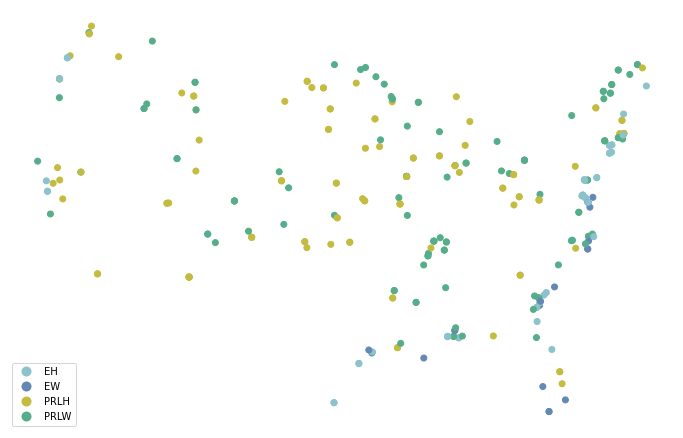

In [8]:
# make geodataframe
sites_gdf = gpd.GeoDataFrame(sites.copy(), geometry=gpd.points_from_xy(sites[("Longitude", "2016")], sites[("Latitude", "2016")]))
# set existing CRS
sites_gdf[("geometry", "")].set_crs("EPSG:4269", inplace=True)
#sites_gdf.set_geometry(("geometry", ""), inplace=True)
# reproject
sites_gdf[("geometry", "")] = sites_gdf[("geometry", "")].to_crs(global_crs)
# set new CRS
#sites_gdf[("geometry", "")].set_crs(global_crs, inplace=True)
sites_gdf.set_geometry(("geometry", ""), inplace=True)

# plot result
fig, ax = plt.subplots()
sites_gdf.plot(column=("WetlandCat","2016"), legend=True, cmap=gen_cmap(catcolors), ax=ax)
ax.axis("off")
fig.set_size_inches(12, 12)
plt.show()

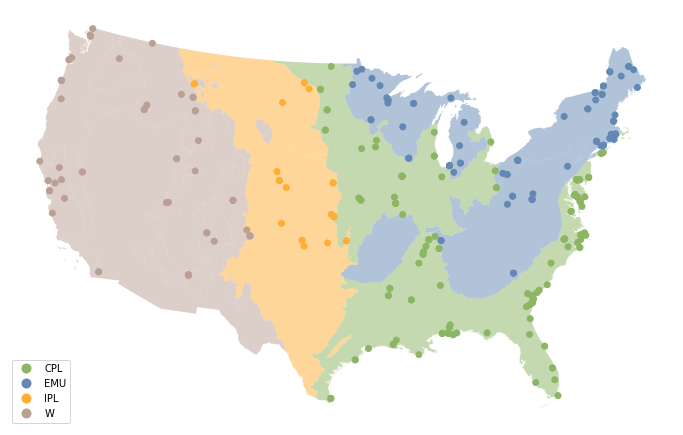

In [9]:
# get ecoregions, convert from 9-level to 4-level for NWCA
#ecoregions = gpd.read_file(os.path.join("data", "ecoregions", "Aggr_Ecoregions_2015.shp")).to_crs(global_crs)
ecoregions = unzip_shapefile("Aggr_Ecoregions_2015.zip").to_crs(global_crs)
region_names = ["CPL", "EMU", "IPL", "W"]
region_colors = ["#8CB564", "#6388B4", "#FFAE34", "#BAA094"]
ecoregions["WSA4"] = ["EMU" if x in ["NAP", "SAP", "UMW"]
                        else "IPL" if x in ["NPL", "SPL"]
                        else "W" if x in ["XER", "WMT"]
                        else "CPL" for x in ecoregions["WSA9"]]
ecoregions["WSA4"] = ecoregions["WSA4"].astype("category").cat.set_categories(region_names)
points = gpd.GeoDataFrame(flatten_columns(gpd.GeoDataFrame(sites_gdf.geometry.copy())), crs=sites_gdf.geometry.crs)
site_regions = gpd.sjoin(points, ecoregions, how="left", op="within")

# plot ecoregions by site
fig, ax = plt.subplots()
ecoregions.plot(column="WSA4", ax=ax, alpha=0.5, cmap=gen_cmap(region_colors))
site_regions.plot(column="WSA4", ax=ax, legend=True, cmap=gen_cmap(region_colors))
ax.axis("off")
fig.set_size_inches(12, 12)
plt.show()

# add to site table
sites["ecoregion"] = site_regions["WSA4"]

# Terraclimate 

In [10]:
# TERRACLIMATE
# catalog: http://thredds.northwestknowledge.net:8080/thredds/catalog/TERRACLIMATE_ALL/data/catalog.html

# extracting values takes about 30 seconds for each var/year in addition to download time (~100 MB each)
def extract_values_to_points(ds: xr.Dataset, varname: str, pts: gpd.GeoSeries) -> pd.DataFrame:
    def timeseries_from_raster(pt: shapely.geometry.Point) -> pd.Series:
        return ds.sel(lon=pt.x, lat=pt.y, method="nearest").to_dataframe()[varname]
    return pts.apply(timeseries_from_raster).stack().rename(varname)

# define parameters of files to get
tc_vars = ["ppt", "pet", "aet", "def", "PDSI"] 
dirname = "tc"

# get buffers from which to extract points
#buffers = sites_gdf.buffer(distance=40).rename("geometry").reset_index().to_crs("EPSG:4326")
pts = gpd.GeoDataFrame(sites_gdf[("geometry", "")].to_crs("EPSG:4326"))["geometry"]

d = {}
if not os.path.exists(dirname):
    os.mkdir(dirname)
for v in tc_vars:
    # URL for TerraClimate data over contiguous USA for 2007-2016
    url = f"http://thredds.northwestknowledge.net:8080/thredds/ncss/agg_terraclimate_{v}_1958_CurrentYear_GLOBE.nc?var={v}&north=51&west=-125&east=-67&south=24&disableProjSubset=on&horizStride=1&time_start=2007-01-01T00%3A00%3A00Z&time_end=2016-12-31T00%3A00%3A00Z&timeStride=1&accept=netcdf"
    destname = os.path.join(dirname, f"TerraClimate_{v}.nc")
    if not os.path.exists(destname):
        urllib.request.urlretrieve(url, destname)
    with xr.open_dataset(destname).rio.write_crs("EPSG:4326").rio.set_spatial_dims(x_dim="lon", y_dim="lat") as ds:
        d[v] = extract_values_to_points(ds=ds, varname=v, pts=pts)

extracted = (pd.concat(d, names=["varname"])
        .rename("value")
        .unstack("varname")
        .assign(aridity = lambda d: np.where(d["pet"] > 0, d["ppt"] / d["pet"], np.nan))
        .reset_index()
        .assign(year = lambda d: [x.year for x in d["time"]])
        .set_index(["UID11", "UID16", "year", "time"])
)

tc_years = (extracted
        .groupby(["UID11", "UID16", "year"])
        .agg(["min", "mean", "max", "std"])
        .pipe(flatten_columns)
        .rename_axis(["varname"], axis="columns")
)

tc_2007_16 = tc_years.groupby(["UID11", "UID16"]).mean()
tc_2011 = tc_years.loc[idx[:, :, 2011]]
tc_2016 = tc_years.loc[idx[:, :, 2016]]
tc_DIFF = tc_2016 - tc_2011

df_tc = (pd.concat([tc_2007_16.assign(year=""), 
           tc_2011.assign(year="2011"), 
           tc_2016.assign(year="2016"), 
           tc_DIFF.assign(year="DIFF")], axis="rows")
        .set_index("year", append=True)
        .unstack()
)

sites = sites.join(df_tc, how="left")

# logs of variables that are right tailed
vars_to_log = ["def_mean", "def_max"]
for v in vars_to_log:
    for y in ["", "2011", "2016"]:
        sites[(f"log_{v}", y)] = np.where(sites[v, y]>0, np.log(sites[v, y]), np.nan)
    sites[(f"log_{v}", "DIFF")] = sites[(f"log_{v}", "2016")] - sites[(f"log_{v}", "2011")]

#   # create PCA of the AET and Climate Water Deficit from these means
#   X = flatten_columns(sites)[["def_mean", "aet_mean"]]
#   climate_pc = PCA(n_components=2).fit_transform(X)
#   sites[("climate_pc1", "")], sites[("climate_pc2", "")] = zip(*climate_pc)
#   
#   X = flatten_columns(sites)[["def_std", "aet_std"]]
#   climate_std_pc = PCA(n_components=2).fit_transform(X)
#   sites[("climate_std_pc1", "")], sites[("climate_std_pc2", "")] = zip(*climate_std_pc)

X = flatten_columns(sites)[["ppt_mean", "def_mean", "aet_mean"]]
climate_mean_pc = PCA(n_components=2).fit_transform(X)
sites[("climate_mean_pc1", "")], sites[("climate_mean_pc2", "")] = zip(*climate_mean_pc)

X = flatten_columns(sites)[["ppt_std", "def_std", "aet_std"]]
climate_std_pc = PCA(n_components=2).fit_transform(X)
sites[("climate_std_pc1", "")], sites[("climate_std_pc2", "")] = zip(*climate_std_pc)

X = flatten_columns(sites)[["ppt_mean_DIFF", "def_mean_DIFF", "aet_mean_DIFF"]]
climate_diff_pc = PCA(n_components=2).fit_transform(X)
sites[("climate_diff_pc1", "")], sites[("climate_diff_pc2", "")] = zip(*climate_diff_pc)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Exploration of traits data

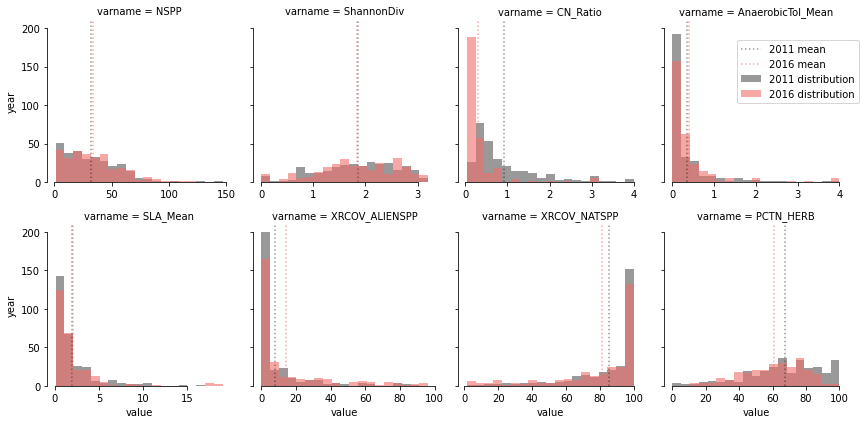

In [11]:
vars_to_plot = [
        "NSPP", "ShannonDiv", 
        "CN_Ratio", #"CN_Variance", 
        "AnaerobicTol_Mean", #"AnaerobicTol_Variance", 
        "SLA_Mean", #"SLA_Variance", 
        #"XN_ALIENSPP", 
        "XRCOV_ALIENSPP", 
        #"XN_NATSPP", 
        "XRCOV_NATSPP", 
        "PCTN_HERB", 
]

def plot_hist_grouped(x, hue, n_bins=10, color=None, palette=None, **kwargs):
    bins = np.linspace(x.min(), x.max(), n_bins)
    for i, (_, x_i) in enumerate(x.groupby(hue)):
        x_mean = x_i.mean()
        #x_std = np.std(x_i)
        #x_ci_low = x_mean - x_std
        #x_ci_high = x_mean + x_std
        if palette:
            #plt.axvspan(xmin=x_ci_low, xmax=x_ci_high, alpha=0.1, color=palette[i])
            plt.hist(x_i, bins, color=palette[i], **kwargs)
            plt.axvline(x=x_mean, linestyle=":", color=palette[i])
        else:
            #plt.axvspan(xmin=x_ci_low, xmax=x_ci_high, alpha=0.1)
            plt.hist(x_i, bins, **kwargs)
            plt.axvline(x=x_mean, linestyle=":")


d = (sites
        .loc[:, idx[:, ("2011", "2016")]]
        .stack("year")
        [vars_to_plot]
        .stack("varname")
        .rename("value")
        .reset_index(["varname", "year"])
        )
g = sns.FacetGrid(data=d, col="varname", col_wrap=4, sharex=False)
g.map(plot_hist_grouped, "value", "year", n_bins=20, palette=["#00000066", "#EF6F6A99"])
#g.add_legend()
g.fig.legend(["2011 mean", "2016 mean", "2011 distribution", "2016 distribution"]).set_bbox_to_anchor((1, 0.9))
sns.despine(trim=True)
plt.show()

# imrpovement: kde histograms, colored by wetland type, rows=year, columns=vars

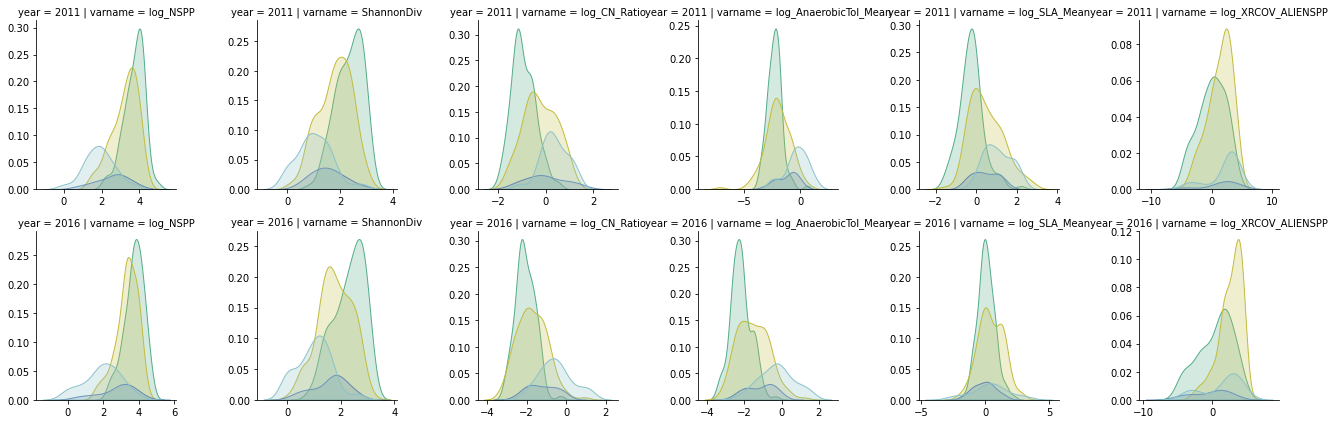

In [12]:
vars_to_plot2 = ["log_NSPP", "ShannonDiv", "log_CN_Ratio", "log_AnaerobicTol_Mean", "log_SLA_Mean", "log_XRCOV_ALIENSPP"]
d = (sites
        .loc[:, idx[:, ("2011", "2016")]]
        .stack("year")
        .set_index(["WetlandCat"], append=True)
        [vars_to_plot2]
        .stack("varname")
        .rename("value")
        .reset_index(["varname", "year", "WetlandCat"])
        .dropna()
        )

d["varname"] = d["varname"].astype("category").cat.set_categories(vars_to_plot2)
d["WetlandCat"] = d["WetlandCat"].astype("category").cat.set_categories(wetlandcats)

g = sns.FacetGrid(data=d, col="varname", row="year", sharex=False, sharey=False)
g.map_dataframe(sns.kdeplot, x="value", hue="WetlandCat", palette=catcolors, shade=True)
g.add_legend()
sns.despine()
#for a in g.axes.flatten():
#    a.set_xticks(np.exp(a.get_xticks()[:-2]))
plt.show()

# horizontal = 2011, vertical = 2016 (above diagonal = increase, below diagonal = decrease )
# update to use proper category order

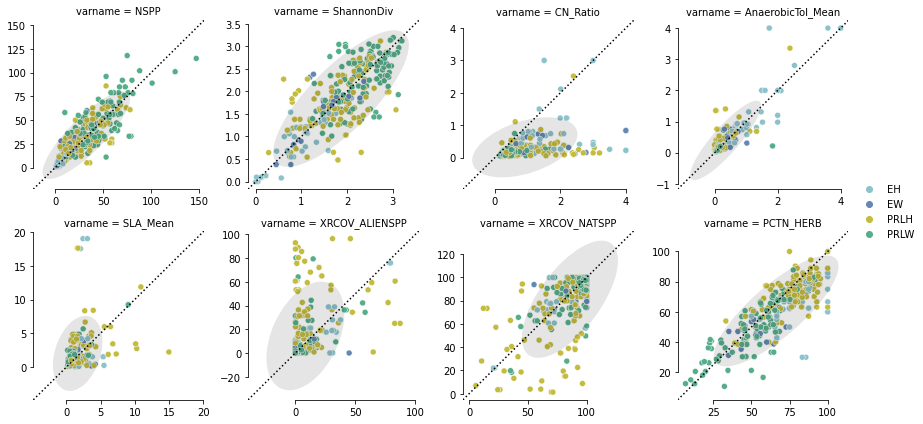

In [13]:
def plot_twoway_symmetrical(*args, **kwargs):
    sp = sns.scatterplot(*args, **kwargs)
    ax = sp.axes
    if "data" in kwargs:
        x = kwargs["data"][kwargs["x"]]
        y = kwargs["data"][kwargs["y"]]
    else:
        x = kwargs["x"]
        y = kwargs["y"]
    ax.add_patch(make_ellipse(x=x, y=y, 
        facecolor="black", alpha=0.1, type="error", n_std=2))
    std_min = min(ax.get_xlim() + ax.get_ylim())
    std_max = max(ax.get_xlim() + ax.get_ylim())
    std_lim = (std_min, std_max)
    ax.set_xlim(std_lim)
    ax.set_ylim(std_lim)
    #ax.set_xticks(ax.get_yticks(minor=False), minor=False)
    #ax.set_xticklabels(ax.get_xticklabels(minor=False), minor=False)
    sns.lineplot(ax=ax, color="black", linestyle=":", x=std_lim, y=std_lim)
    sns.despine(trim=True, ax=ax)
    return sp

d = (sites
        .loc[:, idx[:, ("2011", "2016")]]
        .stack("year")
        .set_index(["WetlandCat"], append=True)
        [vars_to_plot]
        .unstack("year")
        .stack("varname")
        .reset_index(["varname", "WetlandCat"])
        .dropna()
        )

d["varname"] = d["varname"].astype("category").cat.set_categories(vars_to_plot)
d["WetlandCat"] = d["WetlandCat"].astype("category").cat.set_categories(wetlandcats)

g = sns.FacetGrid(data=d, col="varname", col_wrap=4, sharex=False, sharey=False)
g.map_dataframe(plot_twoway_symmetrical, x="2011", y="2016", hue="WetlandCat", ci=False, palette=catcolors)
g.add_legend()
#map(lambda a: a.set_xlim(0), g.axes)
#map(lambda a: a.set_ylim(0), g.axes)
plt.show()

# horizontal = 2011, vertical = 2016 (above diagonal = increase, below diagonal = decrease )
# update to use proper category order

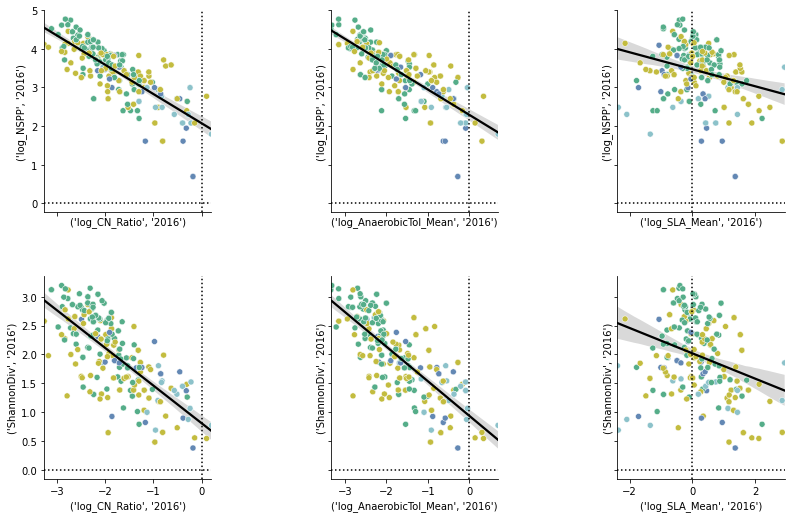

In [14]:
# C:N ratio, Anaerobic tolerance and SLA (specific leaf area)) correlate with changes in species richness or Shannon diversity

y_vars = ["log_NSPP", "ShannonDiv"]
x_vars = ["log_CN_Ratio", "log_AnaerobicTol_Mean", "log_SLA_Mean"]
z_vars = ["WetlandCat"]
d = sites[y_vars + x_vars + z_vars].dropna()

fig, axs = plt.subplots(len(y_vars), len(x_vars), sharex="col", sharey="row")
for i, y in enumerate(y_vars):
    for j, x in enumerate(x_vars):
        sns.regplot(ax=axs[i, j], x=d[(x, "2016")], y=d[(y, "2016")], line_kws={"color": "black"}, scatter=False)
        sns.scatterplot(ax=axs[i, j], x=d[(x, "2016")], y=d[(y, "2016")], hue=d[("WetlandCat", "2016")], legend=False, palette=catcolors)
        axs[i, j].axhline(y=0, color="black", linestyle=":")
        axs[i, j].axvline(x=0, color="black", linestyle=":")
sns.despine()
plt.tight_layout()
fig.set_size_inches(12,8)
plt.show()

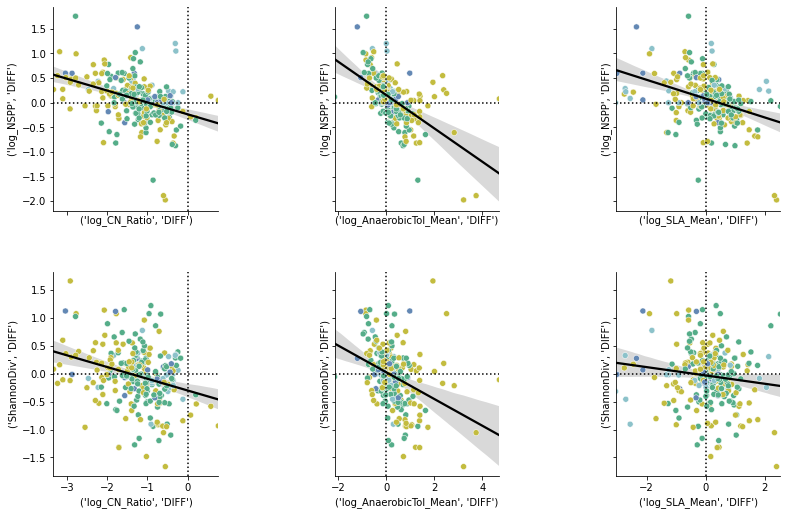

In [15]:
# C:N ratio, Anaerobic tolerance and SLA (specific leaf area)) correlate with changes in species richness or Shannon diversity

y_vars = ["log_NSPP", "ShannonDiv"]
x_vars = ["log_CN_Ratio", "log_AnaerobicTol_Mean", "log_SLA_Mean"]
z_vars = ["WetlandCat"]
d = sites[y_vars + x_vars + z_vars].dropna()

fig, axs = plt.subplots(len(y_vars), len(x_vars), sharex="col", sharey="row")
for i, y in enumerate(y_vars):
    for j, x in enumerate(x_vars):
        sns.regplot(ax=axs[i, j], x=d[(x, "DIFF")], y=d[(y, "DIFF")], line_kws={"color": "black"}, scatter=False)
        sns.scatterplot(ax=axs[i, j], x=d[(x, "DIFF")], y=d[(y, "DIFF")], hue=d[("WetlandCat", "2016")], legend=False, palette=catcolors)
        axs[i, j].axhline(y=0, color="black", linestyle=":")
        axs[i, j].axvline(x=0, color="black", linestyle=":")
sns.despine()
plt.tight_layout()
fig.set_size_inches(12,8)
plt.show()

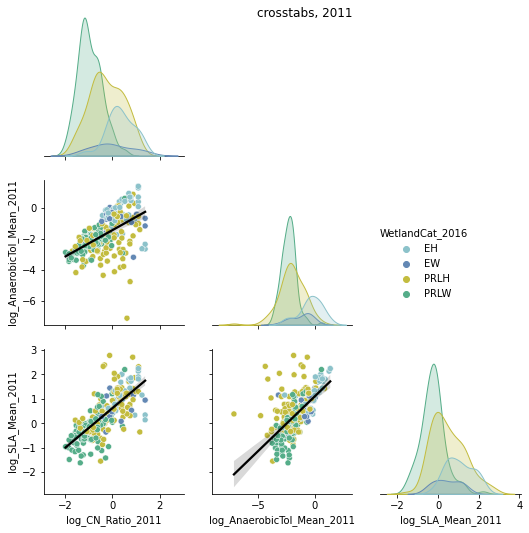

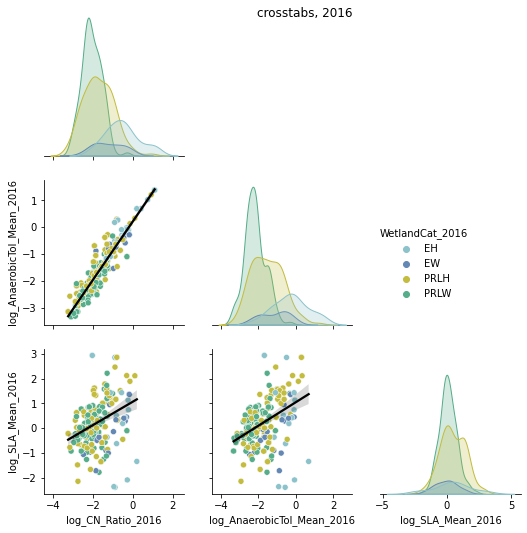

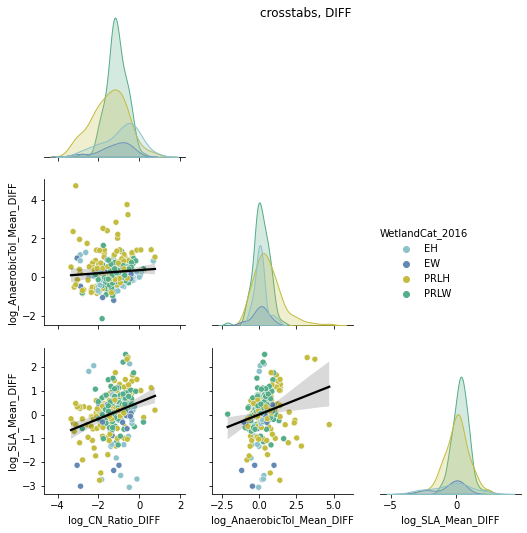

In [16]:
#def plot_diag(*args, **kwargs):
#    g = sns.kdeplot(*args, **kwargs)
#    g.axes.axvline(x=0, color="black", linestyle=":")
#    return g

def plot_offdiag(hue, palette, *args, **kwargs):
    g = sns.scatterplot(x=kwargs["x"], y=kwargs["y"], hue=hue, palette=palette)
    h = sns.regplot(x=kwargs["x"], y=kwargs["y"], scatter=False, ax=g.axes, color="black")
#    g.axes.axhline(y=0, color="black", linestyle=":")
#    g.axes.axvline(x=0, color="black", linestyle=":")
    return g

for yr in ["2011", "2016", "DIFF"]:
    d = flatten_columns(sites)[["WetlandCat_2016", f"log_CN_Ratio_{yr}", f"log_AnaerobicTol_Mean_{yr}", f"log_SLA_Mean_{yr}"]] #, f"log_NSPP_{yr}", f"ShannonDiv_{yr}"]] #.dropna()
    #g = sns.pairplot(d, corner=True, kind="scatter", diag_kind="kde", hue="WetlandCat_2016", palette=catcolors)
    g = sns.PairGrid(d, corner=True, hue="WetlandCat_2016")
#    g.map_diag(plot_diag, hue=d["WetlandCat_2016"], palette=catcolors, fill=True)
    g.map_diag(sns.kdeplot, hue=d["WetlandCat_2016"], palette=catcolors, fill=True)
    g.map_offdiag(plot_offdiag, hue=d["WetlandCat_2016"], palette=catcolors)
    g.fig.suptitle(f"crosstabs, {yr}")
    g.add_legend()
    g._legend.set_bbox_to_anchor(((3/4), (1/2)))
    plt.show()
# note high correlation between anaerobic tol and CN ratio in 2016

NSPP_DIFF
               count  mean   std    min   25%  50%   75%   max
REF_NWCA_2011                                                 
L              51.00  0.14 10.93 -29.00 -2.50 0.00  4.00 43.00
I             139.00  3.27 14.51 -46.00 -2.00 2.00 12.00 48.00
M              99.00  0.11 11.23 -33.00 -4.50 0.00  6.00 29.00
ShannonDiv_DIFF
               count  mean  std   min   25%   50%  75%  max
REF_NWCA_2011                                              
L              51.00 -0.04 0.40 -0.96 -0.28 -0.02 0.20 1.04
I             139.00 -0.01 0.48 -1.32 -0.25 -0.03 0.24 1.22
M              99.00 -0.05 0.56 -1.66 -0.39  0.04 0.21 1.66


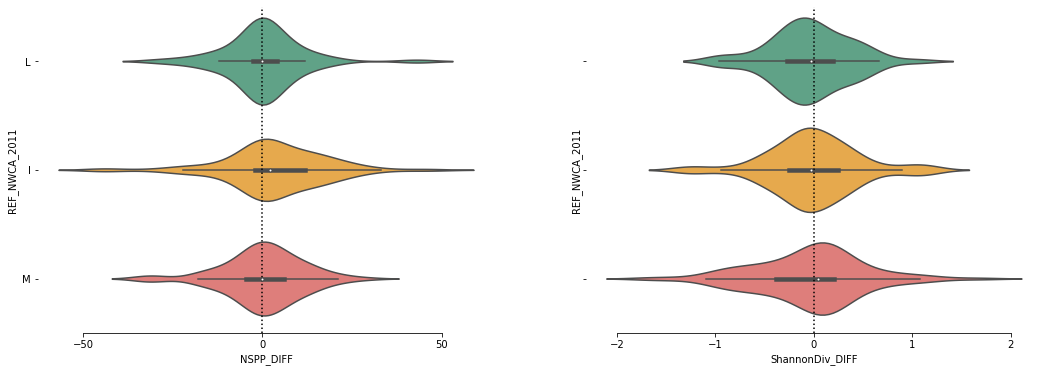

In [17]:
fig, ax = plt.subplots(1, 2, sharey=True)
palette = ["#55AD89", "#FFAE34", "#EF6F6A"]
sns.violinplot(data=flatten_columns(sites), x="NSPP_DIFF", y="REF_NWCA_2011", palette=palette, ax=ax[0])
sns.violinplot(data=flatten_columns(sites), x="ShannonDiv_DIFF", y="REF_NWCA_2011", palette=palette, ax=ax[1])
ax[0].axvline(0, c="black", ls=":")
ax[1].axvline(0, c="black", ls=":")
sns.despine(trim=True, left=True)
fig.set_size_inches(18,6)

print("NSPP_DIFF")
print(flatten_columns(sites).groupby("REF_NWCA_2011")["NSPP_DIFF"].describe())
print("ShannonDiv_DIFF")
print(flatten_columns(sites).groupby("REF_NWCA_2011")["ShannonDiv_DIFF"].describe())

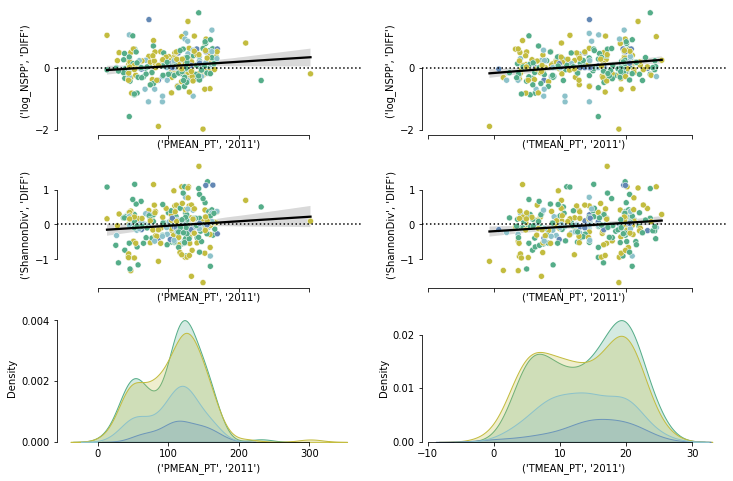

In [18]:
# temperature and precipitation

y_vars = ["log_NSPP", "ShannonDiv"]
x_vars = ["PMEAN_PT", "TMEAN_PT"]
z_vars = ["WetlandCat"]
d = sites[y_vars + x_vars + z_vars].dropna()

fig, axs = plt.subplots(len(y_vars) + 1, len(x_vars), sharex="col", sharey=False)
for j, x in enumerate(x_vars):
    for i, y in enumerate(y_vars):
        sns.regplot(ax=axs[i, j], x=d[(x, "2011")], y=d[(y, "DIFF")], line_kws={"color": "black"}, scatter=False)
        sns.scatterplot(ax=axs[i, j], x=d[(x, "2011")], y=d[(y, "DIFF")], hue=d[("WetlandCat", "2016")], legend=False, palette=catcolors)
        axs[i, j].axhline(y=0, color="black", linestyle=":")
    sns.kdeplot(ax=axs[-1, j], x=d[(x, "2011")], hue=d[("WetlandCat", "2016")], palette=catcolors, legend=False, shade=True)
sns.despine(trim=True)
#plt.tight_layout()
fig.set_size_inches(12,8)
plt.show()

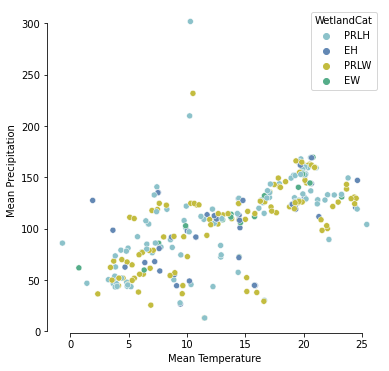

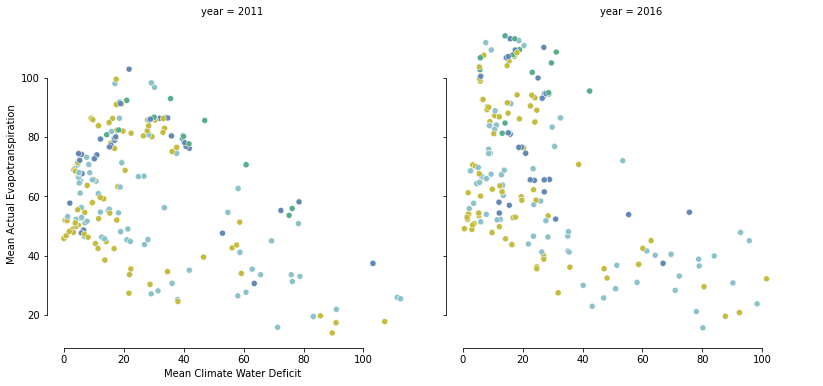

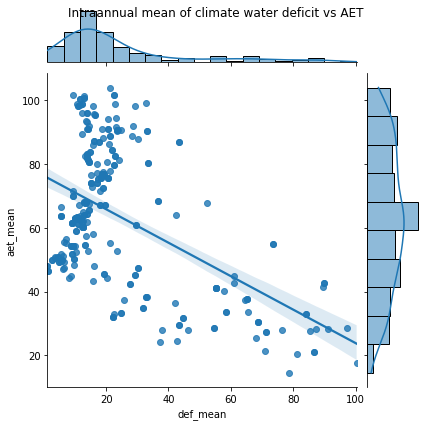

In [19]:
d = sites.stack("year").loc[idx[:, :, "2011"]]
fig, ax = plt.subplots()
sns.scatterplot(data=d, x="TMEAN_PT", y="PMEAN_PT", hue="WetlandCat", palette=catcolors, ax=ax)
ax.set(xlabel="Mean Temperature", ylabel="Mean Precipitation")
fig.set_size_inches(6,6)
sns.despine(trim=True)
plt.show()

d = sites.stack("year").query("year=='2011' | year=='2016'").reset_index("year")
g = sns.FacetGrid(data=d, col="year")
g.map_dataframe(sns.scatterplot, x="def_mean", y="aet_mean", hue="WetlandCat", palette=catcolors)
g.axes[0,0].set(xlabel="Mean Climate Water Deficit", ylabel="Mean Actual Evapotranspiration")
g.fig.set_size_inches(12,6)
sns.despine(trim=True)
plt.show()

#   for yr in [2011, 2016]:
#       g = sns.jointplot(data=flatten_columns(sites), x=f"def_mean_{yr}", y=f"aet_mean_{yr}", hue=f"WetlandCat_{yr}", palette=catcolors, ax=ax)
#       g.ax_joint.set(xlabel="Climate Water Deficit", ylabel="Actual Evapotranspiration")
#       fig.set_size_inches(12,12)
#       sns.despine(trim=True)
#       plt.show()
#   
#   a = sns.kdeplot(data=flatten_columns(sites), x="def_mean_DIFF", hue="WetlandCat_2016", palette=catcolors, shade=True)
#   a.set_title("$\Delta$ Climate Water Deficit")
#   a.axvline(x=0, color="black", ls=":")
#   sns.despine()

#   g = sns.jointplot(data=flatten_columns(sites), x="def_mean_DIFF", y="aet_mean_DIFF", hue="WetlandCat_2016", palette=catcolors, ax=ax)
#   g.ax_joint.set(xlabel="$\Delta$ Climate Water Deficit", ylabel="$\Delta$ Actual Evapotranspiration")
#   g.ax_joint.axvline(x=0, color="black", ls=":")
#   g.ax_joint.axhline(y=0, color="black", ls=":")
#   g.ax_marg_x.axvline(x=0, color="black", ls=":")
#   g.ax_marg_y.axhline(y=0, color="black", ls=":")
#   fig.set_size_inches(12,12)
#   sns.despine(trim=True)
#   plt.show()

g = sns.jointplot(data=flatten_columns(sites), x="def_mean", y="aet_mean", kind="reg")
g.fig.suptitle("Intraannual mean of climate water deficit vs AET")
plt.show()

#   g = sns.jointplot(data=flatten_columns(sites), x="def_max_2011", y="aet_max_2011", kind="reg")
#   g.fig.suptitle("Intraannual maximum climate water deficit vs AET")
#   plt.show()
#   
#   g = sns.jointplot(data=flatten_columns(sites), x="def_std_2011", y="aet_std_2011", kind="reg")
#   g.fig.suptitle("Intraannual variation in climate water deficit vs AET")
#   plt.show()
#   
#   g = sns.jointplot(data=flatten_columns(sites), x="def_mean_DIFF", y="aet_mean_DIFF", kind="reg")
#   g.fig.suptitle("2011-2016 change in climate water deficit vs AET")
#   plt.show()

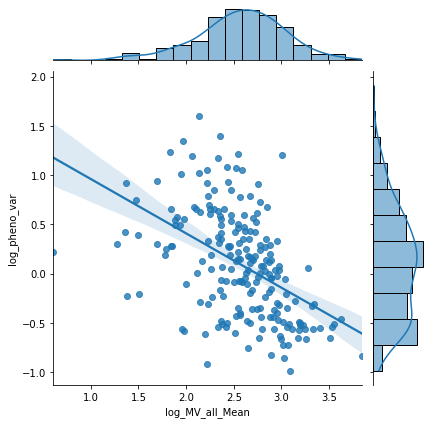

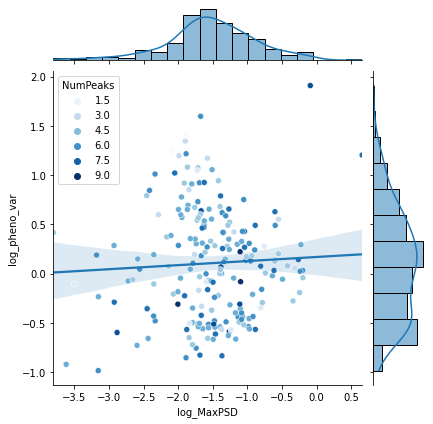

In [20]:
d = flatten_columns(sites)

sns.jointplot(data=d, x="log_MV_all_Mean", y="log_pheno_var", kind="reg")
plt.show()

g = sns.jointplot(data=d, y="log_pheno_var", x="log_MaxPSD", kind="reg", scatter=False)
sns.scatterplot(data=d, y="log_pheno_var", x="log_MaxPSD", hue="NumPeaks", ax=g.ax_joint, palette="Blues")
plt.show()

# Exploratory regression (diversity)


                      Results: Ordinary least squares
Model:                 OLS                 Adj. R-squared:        0.580   
Dependent Variable:    log_NSPP_DIFF       AIC:                   108.4584
Date:                  2021-07-29 18:52    BIC:                   172.4813
No. Observations:      259                 Log-Likelihood:        -36.229 
Df Model:              17                  F-statistic:           15.35   
Df Residuals:          241                 Prob (F-statistic):    1.16e-29
R-squared:             0.607               Scale:                 0.083235
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                  -0.9153   0.1712 -5.3451 0.0000 -1.2509 -0.5797
log_CN_Ratio_DIFF          -0.3135   0.0503 -6.2289 0.0000 -0.4121 -0.2148
log_AnaerobicTol_Mean_DIFF -0.2662   0.0375 -

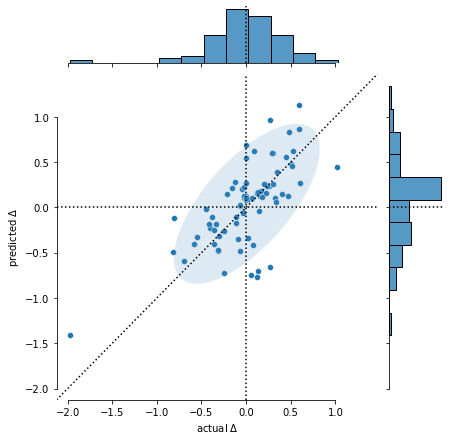

In [21]:
f = """log_NSPP_DIFF ~ 
                            log_CN_Ratio_DIFF + log_AnaerobicTol_Mean_DIFF + log_SLA_Mean_DIFF 
                            + CN_prevalence_2016 + AnTol_prevalence_2016 + SLA_prevalence_2016 
                            + XRCOV_NATSPP_DIFF 
                            + d_estuarine_2016 + d_woody_2016 
                            + d_disturb_I_2011 + d_disturb_M_2011 
                            + PMEAN_PT_2011 + TMEAN_PT_2011 + aet_mean + def_mean + def_mean_DIFF + PDSI_mean_DIFF
"""
d = data=flatten_columns(sites)
y, X = patsy.dmatrices(f, d, return_type="dataframe")

results = smf.ols(formula=f, data=d).fit(cov_type="HC0")

print("\n", results.summary2())
print("\n", "Test for Multicollinearity (VIF) \n", quick_vif(X.iloc[:,1:]))
print("\n", "Test for Heteroskedasticity (LMS) \n", quick_skedtest([results], ["OLS"]))
print("\n", "Sorted by statistical significance")
print(pd.concat([results.params.rename("params"), results.pvalues.rename("pvalues")], axis=1).sort_values("pvalues", ascending=True))

dmat = pd.concat([y, X], axis="columns").dropna()
dmat_scaled = dmat.copy()
dmat_scaled[:] = scale(dmat_scaled[:])
reg_L1 = sm.OLS(endog=dmat_scaled.iloc[:, 0], exog=dmat_scaled.iloc[:, 1:]).fit_regularized(method="sqrt_lasso")
print("\n", "regularized absolute coefficients")
print(reg_L1.params.abs().sort_values(ascending=False))

# test predictive model
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.3, random_state=47)
reg = LinearRegression(normalize=True, copy_X=True, fit_intercept=True)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# join results and plot
g = plot_actual_vs_predicted(actual=y_test.values.flatten(), predicted=y_pred.flatten(), marginal_kws=dict(binwidth=0.25))
g.ax_joint.set_xlabel("actual $\Delta$")
g.ax_joint.set_ylabel("predicted $\Delta$")
g.ax_joint.axhline(y=0, color="black", linestyle=":")
g.ax_joint.axvline(x=0, color="black", linestyle=":")
g.ax_marg_x.axvline(x=0, color="black", linestyle=":")
g.ax_marg_y.axhline(y=0, color="black", linestyle=":")
plt.show()


                      Results: Ordinary least squares
Model:                 OLS                 Adj. R-squared:        0.224   
Dependent Variable:    ShannonDiv_DIFF     AIC:                   338.8850
Date:                  2021-07-29 18:52    BIC:                   402.9079
No. Observations:      259                 Log-Likelihood:        -151.44 
Df Model:              17                  F-statistic:           6.590   
Df Residuals:          241                 Prob (F-statistic):    8.25e-13
R-squared:             0.275               Scale:                 0.20262 
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                  -0.6499   0.2705 -2.4025 0.0163 -1.1801 -0.1197
log_CN_Ratio_DIFF          -0.3261   0.0689 -4.7309 0.0000 -0.4612 -0.1910
log_AnaerobicTol_Mean_DIFF -0.1661   0.0574 -

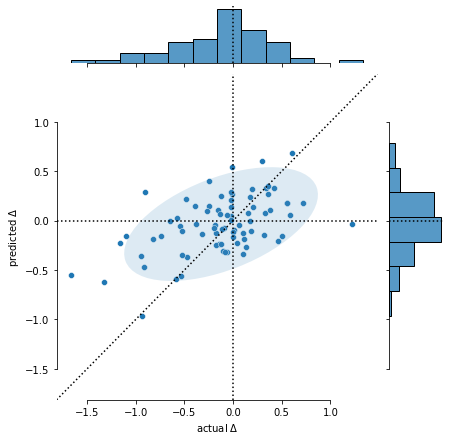

In [22]:
f = """ShannonDiv_DIFF ~ 
                            log_CN_Ratio_DIFF + log_AnaerobicTol_Mean_DIFF + log_SLA_Mean_DIFF 
                            + CN_prevalence_2016 + AnTol_prevalence_2016 + SLA_prevalence_2016 
                            + XRCOV_NATSPP_DIFF 
                            + d_estuarine_2016 + d_woody_2016 
                            + d_disturb_I_2011 + d_disturb_M_2011 
                            + PMEAN_PT_2011 + TMEAN_PT_2011 + aet_mean + def_mean + def_mean_DIFF + PDSI_mean_DIFF
"""

d = data=flatten_columns(sites)
y, X = patsy.dmatrices(f, d, return_type="dataframe")

results = smf.ols(formula=f, data=d).fit(cov_type="HC0")
print("\n", results.summary2())
print("\n", "Test for Multicollinearity (VIF) \n", quick_vif(X.iloc[:,1:]))
print("\n", "Test for Heteroskedasticity (LMS) \n", quick_skedtest([results], ["OLS"]))
print("\n", "Sorted by statistical significance")
print(pd.concat([results.params.rename("params"), results.pvalues.rename("pvalues")], axis=1).sort_values("pvalues", ascending=True))

dmat = pd.concat([y, X], axis="columns").dropna()
dmat_scaled = dmat.copy()
dmat_scaled[:] = scale(dmat_scaled[:])
reg_L1 = sm.OLS(endog=dmat_scaled.iloc[:, 0], exog=dmat_scaled.iloc[:, 1:]).fit_regularized(method="sqrt_lasso")
print("\n", "regularized absolute coefficients")
print(reg_L1.params.abs().sort_values(ascending=False))

# test predictive model
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.3, random_state=47)
reg = LinearRegression(normalize=True, copy_X=True, fit_intercept=True)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# join results and plot
g = plot_actual_vs_predicted(actual=y_test.values.flatten(), predicted=y_pred.flatten(), marginal_kws=dict(binwidth=0.25))
g.ax_joint.set_xlabel("actual $\Delta$")
g.ax_joint.set_ylabel("predicted $\Delta$")
g.ax_joint.axhline(y=0, color="black", linestyle=":")
g.ax_joint.axvline(x=0, color="black", linestyle=":")
g.ax_marg_x.axvline(x=0, color="black", linestyle=":")
g.ax_marg_y.axhline(y=0, color="black", linestyle=":")
plt.show()


                      Results: Ordinary least squares
Model:                  OLS                Adj. R-squared:       0.357    
Dependent Variable:     MV_all_Mean        AIC:                  1171.0140
Date:                   2021-07-29 18:52   BIC:                  1251.5229
No. Observations:       185                Log-Likelihood:       -560.51  
Df Model:               24                 F-statistic:          6.430    
Df Residuals:           160                Prob (F-statistic):   7.60e-14 
R-squared:              0.441              Scale:                28.987   
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                  12.7203   4.8629  2.6158 0.0089  3.1891 22.2514
log_NSPP_DIFF              -2.5020   1.6271 -1.5377 0.1241 -5.6911  0.6871
ShannonDiv_DIFF             0.8226   0.8343  

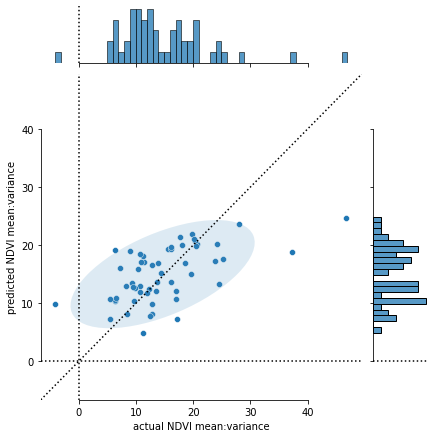

In [23]:
f = """MV_all_Mean ~ 
                            log_NSPP_DIFF + ShannonDiv_DIFF + SLA_Variance_DIFF
                            + log_CN_Ratio_DIFF + log_AnaerobicTol_Mean_DIFF + log_SLA_Mean_DIFF 
                            + CN_prevalence_2016 + AnTol_prevalence_2016 + SLA_prevalence_2016 
                            + XRCOV_NATSPP_DIFF 
                            + d_estuarine_2016 + d_woody_2016 
                            + d_disturb_I_2011 + d_disturb_M_2011 
                            + PMEAN_PT_2011 + TMEAN_PT_2011 + aet_mean + def_mean + def_mean_DIFF + PDSI_mean_DIFF 
                            + aet_std + def_std
                            + NumPeaks + MaxPSD
"""

d = flatten_columns(sites)
y, X = patsy.dmatrices(f, d, return_type="dataframe")

results = smf.ols(formula=f, data=d).fit(cov_type="HC0")
print("\n", results.summary2())
print("\n", "Test for Multicollinearity (VIF) \n", quick_vif(X.iloc[:,1:]))
print("\n", "Test for Heteroskedasticity (LMS) \n", quick_skedtest([results], ["OLS"]))
print("\n", "Sorted by statistical significance")
print(pd.concat([results.params.rename("params"), results.pvalues.rename("pvalues")], axis=1).sort_values("pvalues", ascending=True))

dmat = pd.concat([y, X], axis="columns").dropna()
dmat_scaled = dmat.copy()
dmat_scaled[:] = scale(dmat_scaled[:])
reg_L1 = sm.OLS(endog=dmat_scaled.iloc[:, 0], exog=dmat_scaled.iloc[:, 1:]).fit_regularized(method="sqrt_lasso")
print("\n", "regularized absolute coefficients")
print(reg_L1.params.abs().sort_values(ascending=False))

# test predictive model
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.3, random_state=47)
reg = LinearRegression(normalize=True, copy_X=True, fit_intercept=True)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# join results and plot
g = plot_actual_vs_predicted(actual=y_test.values.flatten(), predicted=y_pred.flatten(), marginal_kws=dict(binwidth=1))
g.ax_joint.set_xlabel("actual NDVI mean:variance")
g.ax_joint.set_ylabel("predicted NDVI mean:variance")
g.ax_joint.axhline(y=0, color="black", linestyle=":")
g.ax_joint.axvline(x=0, color="black", linestyle=":")
g.ax_marg_x.axvline(x=0, color="black", linestyle=":")
g.ax_marg_y.axhline(y=0, color="black", linestyle=":")
plt.show()


                      Results: Ordinary least squares
Model:                 OLS                 Adj. R-squared:        0.577   
Dependent Variable:    log_pheno_var       AIC:                   174.5911
Date:                  2021-07-29 18:52    BIC:                   255.1000
No. Observations:      185                 Log-Likelihood:        -62.296 
Df Model:              24                  F-statistic:           18.60   
Df Residuals:          160                 Prob (F-statistic):    8.79e-35
R-squared:             0.632               Scale:                 0.13276 
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------
Intercept                   0.9014   0.3060  2.9462 0.0032  0.3017  1.5010
log_NSPP_DIFF               0.0522   0.0986  0.5290 0.5968 -0.1411  0.2455
ShannonDiv_DIFF            -0.0168   0.0637 -

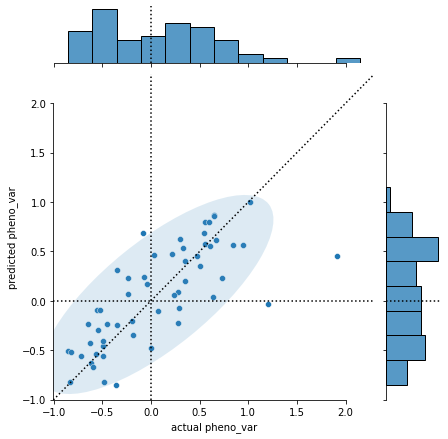

In [24]:
f = """log_pheno_var ~ 
                            log_NSPP_DIFF + ShannonDiv_DIFF + SLA_Variance_DIFF
                            + log_CN_Ratio_DIFF + log_AnaerobicTol_Mean_DIFF + log_SLA_Mean_DIFF 
                            + CN_prevalence_2016 + AnTol_prevalence_2016 + SLA_prevalence_2016 
                            + XRCOV_NATSPP_DIFF 
                            + d_estuarine_2016 + d_woody_2016 
                            + d_disturb_I_2011 + d_disturb_M_2011 
                            + PMEAN_PT_2011 + TMEAN_PT_2011 + aet_mean + def_mean + def_mean_DIFF + PDSI_mean_DIFF 
                            + aet_std + def_std
                            + NumPeaks + log_MaxPSD
"""

d = flatten_columns(sites)
y, X = patsy.dmatrices(f, d, return_type="dataframe")

results = smf.ols(formula=f, data=d).fit(cov_type="HC0")
print("\n", results.summary2())
print("\n", "Test for Multicollinearity (VIF) \n", quick_vif(X.iloc[:,1:]))
print("\n", "Test for Heteroskedasticity (LMS) \n", quick_skedtest([results], ["OLS"]))
print("\n", "Sorted by statistical significance")
print(pd.concat([results.params.rename("params"), results.pvalues.rename("pvalues")], axis=1).sort_values("pvalues", ascending=True))

dmat = pd.concat([y, X], axis="columns").dropna()
dmat_scaled = dmat.copy()
dmat_scaled[:] = scale(dmat_scaled[:])
reg_L1 = sm.OLS(endog=dmat_scaled.iloc[:, 0], exog=dmat_scaled.iloc[:, 1:]).fit_regularized(method="sqrt_lasso")
print("\n", "regularized absolute coefficients")
print(reg_L1.params.abs().sort_values(ascending=False))

# test predictive model
y_train, y_test, X_train, X_test = train_test_split(y, X, test_size=0.3, random_state=47)
reg = LinearRegression(normalize=True, copy_X=True, fit_intercept=True)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# join results and plot
g = plot_actual_vs_predicted(actual=y_test.values.flatten(), predicted=y_pred.flatten(), marginal_kws=dict(binwidth=0.25))
g.ax_joint.set_xlabel("actual pheno_var")
g.ax_joint.set_ylabel("predicted pheno_var")
g.ax_joint.axhline(y=0, color="black", linestyle=":")
g.ax_joint.axvline(x=0, color="black", linestyle=":")
g.ax_marg_x.axvline(x=0, color="black", linestyle=":")
g.ax_marg_y.axhline(y=0, color="black", linestyle=":")
plt.show()

# regression output (diversity) with different sets of variables

In [25]:
def exec_ols(y: pd.Series, X: pd.DataFrame, standardize=True):
    dmat = pd.concat([y, X], axis="columns").dropna()
    if standardize:
        dmat[:] = scale(dmat[:]) # standardize the variables and don't fit intercept
        reg = sm.OLS(endog=dmat.iloc[:, 0], exog=dmat.iloc[:, 1:]).fit(covtype="HC0")
    else:
        reg = sm.OLS(endog=dmat.iloc[:, 0], exog=dmat.iloc[:, 1:].assign(intercept=1)).fit(covtype="HC0")
    return reg #(reg.rsquared_adj, reg.params, reg.pvalues)

def fit_models(df: pd.DataFrame, ys: list, Xs: dict) -> pd.DataFrame:
    regs = [[exec_ols(y = df[y], X = df[Xs[m]]) for m in Xs] for y in ys]
    regs = pd.DataFrame(regs, index=ys, columns=Xs).stack().rename("model")
    return regs

def output_results(regs: pd.Series) -> pd.DataFrame:

    out_rsq = regs.apply(lambda x: x.rsquared).rename_axis(["y", "model"]).rename("_outputs")
    out_aic = regs.apply(lambda x: x.aic).rename_axis(["y", "model"]).rename("_outputs")
    #out_aicn = out_aic.groupby("y").transform(lambda x: ((x - x.min()) / (x.max() - x.min()))) # normalized AIC

#    out_f = regs.apply(lambda x: x.fvalue).rename_axis(["y", "model"]).rename("_outputs")
#    out_fp = regs.apply(lambda x: x.f_pvalue).rename_axis(["y", "model"]).rename("_outputs")

    params = regs.apply(lambda x: x.params).rename_axis(["variable"], axis="columns").rename_axis(["y", "model"])
    pvalues = regs.apply(lambda x: x.pvalues).rename_axis(["variable"], axis="columns").rename_axis(["y", "model"])
    
    # pretty print
    params = params.applymap(lambda x: f"+{abs(x):0.2f}" if x>0 else f"−{abs(x):0.2f}" if x<0 else "—" if x==0 else "").applymap(lambda x: "" if x=="nan" else x)
    #pvalues = pvalues.applymap(lambda x: f"**{x:0.2f}" if x<0.05 else f"{x:0.2f}").applymap(lambda x: "" if x=="nan" else x)
    pvalues = pvalues.applymap(lambda x: "***" if x<0.01 else "**" if x<0.05 else "*" if x<0.1 else "").applymap(lambda x: "" if x=="nan" else x)

    if "intercept" in params.columns:
        varnames = list(params.columns.drop("intercept")) + ["intercept"] + ["_outputs"]
    else:
        varnames = list(params.columns) + ["_outputs"]
    varnames_dtype = pd.CategoricalDtype(categories=reversed(varnames), ordered=True)
    params.columns = params.columns.astype(varnames_dtype)
    pvalues.columns = pvalues.columns.astype(varnames_dtype)

    return (pd.concat([params.T.assign(output="coeff"), 
                pvalues.T.assign(output="P"), 
                pd.DataFrame(out_rsq).T.assign(output="R2_adj"),
                pd.DataFrame(out_aic).T.assign(output="AIC"),
                #pd.DataFrame(out_aicn).T.assign(output="~AIC"),
#                pd.DataFrame(out_f).T.assign(output="F"),
#                pd.DataFrame(out_fp).T.assign(output="P(F)"),
                ])
            .set_index(["output"], append=True)
            .sort_index(level=0, ascending=False)
            .fillna("")
            )

def test_vif(df: pd.DataFrame, Xs: list, sqrt: bool=True):
    def qvif(d):
        v = [variance_inflation_factor(d.values, i) for i in range(d.shape[1])]
        return pd.Series(v, index = d.columns)
    vif = pd.DataFrame({k: qvif(df[Xs[k]].dropna()) for k in Xs})
    vif = vif.reindex(vif.max(axis="columns").sort_values(ascending=False).index)
    if sqrt:
        return np.sqrt(vif)
    else:
        return vif

def test_sked(regs: list):
    s = regs.apply(lambda m: het_breuschpagan(m.resid, m.model.exog))
    hbp = pd.DataFrame.from_dict(dict(zip(s.index, s.values)))
    hbp.index = ["LMS", "P(LMS)", "F", "P(F)"]
    return hbp

In [26]:
# dependent variables for models of taxonomic diversity
vars_dif_taxo_div = ["log_NSPP_DIFF", "ShannonDiv_DIFF"]

# groups of x variables used in diversity models
vars_dif_traits = ["log_SLA_Mean_DIFF", "log_CN_Ratio_DIFF", "log_AnaerobicTol_Mean_DIFF"]
#vars_dif_traits = ["trait_diff_pc1", "trait_diff_pc2"]
vars_dif_native = ["XRCOV_NATSPP_2011", "XRCOV_NATSPP_DIFF"]  # ADDED 27 JUL 2021: baseline in addition to diff
vars_dif_climate = ["ppt_mean_DIFF", "def_mean_DIFF"]
#vars_dif_climate = ["climate_diff_pc1", "climate_diff_pc2"]
vars_climate = ["ppt_mean", "aet_mean", "def_mean"]
#vars_climate = ["climate_mean_pc1", "climate_mean_pc2"] 
vars_disturb = ["d_disturb_I_2011", "d_disturb_M_2011"]
vars_attributes = ["d_estuarine_2011", "d_woody_2011"]
vars_traits_prev = ["CN_prevalence_2016", "AnTol_prevalence_2016", "SLA_prevalence_2016"]

# ADDED 27 JUL 2021
vars_traits_baseline = ["log_SLA_Mean_2011", "log_CN_Ratio_2011", "log_AnaerobicTol_Mean_2011"]

# order of models to test
dmodels = {
        "d1":   vars_attributes + vars_climate + vars_dif_climate + vars_disturb,
        "d2":   vars_attributes + vars_climate + vars_dif_climate + vars_disturb + vars_traits_baseline + vars_dif_traits,
        "d3":   vars_attributes + vars_climate + vars_dif_climate + vars_disturb + vars_traits_baseline + vars_dif_traits + vars_traits_prev,
        "full": vars_attributes + vars_climate + vars_dif_climate + vars_disturb + vars_traits_baseline + vars_dif_traits + vars_traits_prev + vars_dif_native,
        "d5":   vars_dif_traits
        }

# dependent variables for models of diversity
vars_stability = ["MV_all_Mean", "MV_all_Max", "log_pheno_var"]

# groups of x variables (in addition to groups previously defined)
vars_stab_ts = ["NumPeaks", "log_MaxPSD"]
vars_dif_func_div = ["SLA_Variance_DIFF"]
vars_climate_variability = ["ppt_std", "aet_std", "def_std"]
#vars_climate_variability = ["climate_std_pc1", "climate_std_pc2"]

# order of models to test
smodels = {
        "s1":   vars_attributes + vars_climate + vars_climate_variability + vars_dif_climate + vars_disturb,
        "s2":   vars_attributes + vars_climate + vars_climate_variability + vars_dif_climate + vars_disturb + vars_stab_ts,
        "s3":   vars_attributes + vars_climate + vars_climate_variability + vars_dif_climate + vars_disturb + vars_dif_taxo_div + vars_dif_func_div,
        "s4":   vars_attributes + vars_climate + vars_climate_variability + vars_dif_climate + vars_disturb + vars_stab_ts + vars_dif_taxo_div + vars_dif_func_div,
        "full": vars_attributes + vars_climate + vars_climate_variability + vars_dif_climate + vars_disturb + vars_stab_ts + vars_dif_taxo_div + vars_dif_func_div + vars_traits_baseline + vars_dif_traits + vars_traits_prev + vars_dif_native,
        "s6":   vars_stab_ts,
        "s7":   vars_stab_ts + vars_dif_taxo_div + vars_dif_func_div + vars_dif_traits + vars_traits_baseline + vars_traits_prev + vars_dif_native + vars_disturb,
        }

df = flatten_columns(sites)

In [27]:
regs_diversity = fit_models(df=df, ys=vars_dif_taxo_div, Xs=dmodels)
print("\n", "multicollinearity test (root VIF)")
print(test_vif(df, dmodels, sqrt=True)) # root VIF > 4 (rule of thumb) indicates collinearity
print("\n", "heteroskedasticity test (LMS)")
print(test_sked(regs_diversity).T) # significant LMS indicates heteroskedasticity
print("\n", "regression results")
output_results(regs_diversity)


 multicollinearity test (root VIF)
                             d1   d2    d3  full   d5
log_AnaerobicTol_Mean_2011  nan 7.90 14.12 14.69  nan
log_CN_Ratio_DIFF           nan 4.83  9.02  9.18 1.04
AnTol_prevalence_2016       nan  nan  6.95  7.65  nan
CN_prevalence_2016          nan  nan  6.28  6.55  nan
aet_mean                   5.08 5.54  6.13  6.52  nan
log_CN_Ratio_2011           nan 3.82  5.78  5.82  nan
log_AnaerobicTol_Mean_DIFF  nan 2.85  5.06  5.23 1.06
XRCOV_NATSPP_2011           nan  nan   nan  4.98  nan
ppt_mean                   4.55 4.65  4.70  4.78  nan
SLA_prevalence_2016         nan  nan  3.36  3.40  nan
d_disturb_I_2011           1.88 2.09  2.14  2.14  nan
def_mean                   1.57 1.91  2.10  2.13  nan
log_SLA_Mean_2011           nan 1.66  1.93  1.96  nan
d_disturb_M_2011           1.71 1.90  1.93  1.93  nan
d_woody_2011               1.46 1.79  1.85  1.90  nan
def_mean_DIFF              1.74 1.73  1.79  1.88  nan
ppt_mean_DIFF              1.57 1.51  1.53  1.

y                                 log_NSPP_DIFF         ... ShannonDiv_DIFF       
model                                        d1     d2  ...            full     d5
                           output                       ...                       
d_estuarine_2011           coeff          +0.03  +0.17  ...           +0.06       
                           P                       ***  ...                       
d_woody_2011               coeff          −0.02  −0.06  ...           +0.05       
                           P                            ...                       
ppt_mean                   coeff          +0.05  −0.01  ...           +0.02       
                           P                            ...                       
aet_mean                   coeff          +0.05  +0.07  ...           −0.12       
                           P                            ...                       
def_mean                   coeff          +0.18  +0.12  ...           −0.09       
                           P                 **      *  ...                       
ppt_mean_DIFF              coeff          +0.05  +0.10  ...           −0.08       
                           P                            ...                       
def_mean_DIFF              coeff          −0.01  +0.13  ...           −0.05       
                           P                         *  ...                       
d_disturb_I_2011           coeff          +0.13  +0.10  ...           +0.01       
                           P                            ...                       
d_disturb_M_2011           coeff          +0.01  +0.13  ...           +0.09       
                           P                        **  ...                       
log_SLA_Mean_2011          coeff                 +0.36  ...           +0.22       
                           P                       ***  ...              **       
log_CN_Ratio_2011          coeff                 −0.18  ...           −0.41       
                           P                            ...                       
log_AnaerobicTol_Mean_2011 coeff                 −0.20  ...           +0.24       
                           P                            ...                       
log_SLA_Mean_DIFF          coeff                 −0.06  ...           +0.16  +0.00
                           P                            ...               *       
log_CN_Ratio_DIFF          coeff                 −0.30  ...           −0.75  −0.26
                           P                       ***  ...             ***    ***
log_AnaerobicTol_Mean_DIFF coeff                 −0.64  ...           −0.04  −0.33
                           P                       ***  ...                    ***
CN_prevalence_2016         coeff                        ...           +0.27       
                           P                            ...                       
AnTol_prevalence_2016      coeff                        ...           +0.02       
                           P                            ...                       
SLA_prevalence_2016        coeff                        ...           −0.22       
                           P                            ...              **       
XRCOV_NATSPP_2011          coeff                        ...           +0.05       
                           P                            ...                       
XRCOV_NATSPP_DIFF          coeff                        ...           +0.08       
                           P                            ...                       
_outputs                   R2_adj          0.04   0.58  ...            0.29   0.20
                           AIC           826.10 541.32  ...          690.21 686.78

[42 rows x 10 columns]

In [28]:
regs_stability = fit_models(df=df, ys=vars_stability, Xs=smodels)
print("\n", "multicollinearity test (root VIF)")
print(test_vif(df, smodels, sqrt=True)) # root VIF > 2 (rule of thumb) indicates collinearity
print("\n", "heteroskedasticity test (LMS)")
print(test_sked(regs_stability).T) # significant LMS indicates heteroskedasticity
print("\n", "regression results")
output_results(regs_stability)


 multicollinearity test (root VIF)
                             s1   s2   s3   s4  full   s6    s7
log_AnaerobicTol_Mean_2011  nan  nan  nan  nan 16.20  nan 13.86
log_CN_Ratio_DIFF           nan  nan  nan  nan 11.35  nan  9.35
ppt_mean                   9.10 9.01 9.31 9.16 10.49  nan   nan
AnTol_prevalence_2016       nan  nan  nan  nan  7.96  nan  6.93
CN_prevalence_2016          nan  nan  nan  nan  7.58  nan  6.18
ppt_std                    6.61 6.47 6.72 6.55  7.29  nan   nan
def_std                    6.63 6.69 6.65 6.73  7.28  nan   nan
aet_mean                   6.50 6.54 6.55 6.61  7.27  nan   nan
aet_std                    4.18 4.93 4.23 4.96  7.27  nan   nan
log_CN_Ratio_2011           nan  nan  nan  nan  6.51  nan  5.76
def_mean                   5.28 5.67 5.31 5.73  6.23  nan   nan
log_AnaerobicTol_Mean_DIFF  nan  nan  nan  nan  5.97  nan  5.05
XRCOV_NATSPP_2011           nan  nan  nan  nan  5.74  nan  4.49
SLA_prevalence_2016         nan  nan  nan  nan  4.01  nan  3.60
NumP

y                                 MV_all_Mean         ... log_pheno_var       
model                                      s1     s2  ...            s6     s7
                           output                     ...                     
d_estuarine_2011           coeff        −0.09  −0.09  ...                     
                           P                          ...                     
d_woody_2011               coeff        +0.23  +0.23  ...                     
                           P              ***    ***  ...                     
ppt_mean                   coeff        −0.42  −0.42  ...                     
                           P                *      *  ...                     
aet_mean                   coeff        +0.66  +0.66  ...                     
                           P              ***    ***  ...                     
def_mean                   coeff        +0.17  +0.17  ...                     
                           P                          ...                     
ppt_std                    coeff        +0.33  +0.33  ...                     
                           P               **     **  ...                     
aet_std                    coeff        −0.31  −0.32  ...                     
                           P              ***    ***  ...                     
def_std                    coeff        −0.42  −0.42  ...                     
                           P               **      *  ...                     
ppt_mean_DIFF              coeff        −0.08  −0.09  ...                     
                           P                          ...                     
def_mean_DIFF              coeff        +0.35  +0.35  ...                     
                           P              ***     **  ...                     
d_disturb_I_2011           coeff        +0.00  +0.00  ...                −0.08
                           P                          ...                     
d_disturb_M_2011           coeff        −0.00  −0.00  ...                −0.10
                           P                          ...                     
NumPeaks                   coeff               −0.01  ...         −0.11  −0.08
                           P                          ...                     
log_MaxPSD                 coeff               −0.01  ...         +0.06  +0.13
                           P                          ...                    *
log_NSPP_DIFF              coeff                      ...                −0.21
                           P                          ...                    *
ShannonDiv_DIFF            coeff                      ...                +0.08
                           P                          ...                     
SLA_Variance_DIFF          coeff                      ...                −0.03
                           P                          ...                     
log_SLA_Mean_2011          coeff                      ...                −0.18
                           P                          ...                     
log_CN_Ratio_2011          coeff                      ...                −1.66
                           P                          ...                  ***
log_AnaerobicTol_Mean_2011 coeff                      ...                +2.37
                           P                          ...                  ***
log_SLA_Mean_DIFF          coeff                      ...                −0.20
                           P                          ...                     
log_CN_Ratio_DIFF          coeff                      ...                −1.69
                           P                          ...                  ***
log_AnaerobicTol_Mean_DIFF coeff                      ...                +1.55
                           P                          ...                  ***
CN_prevalence_2016         coeff                      ...                +0.63
                           P                      

# Model selection 

## option 1: cross validaiton

Use cross validation to test models with all possible combinations of vars

Note: There are $\sum_{k=1}^{n} {n\choose k} = 2^n$ possible combos for $n$ variables, so there is an upper limit to the number of variables to test this way in any reasonable amount of time

In [29]:
# disable for now because this is computationally expensive
if False:

    from itertools import combinations
    from sklearn.model_selection import train_test_split, cross_validate
    from sklearn.model_selection import KFold

    cv = KFold(n_splits=3, shuffle=True, random_state=47) # KFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit, etc.
    scoring = ["r2", "neg_root_mean_squared_error", "neg_median_absolute_error"]

    models = {
        "OLS": LinearRegression(fit_intercept=True, normalize=True, copy_X=True),
    }

    y_vars = ["log_NSPP_DIFF", "ShannonDiv_DIFF"]
    X_vars = ["log_CN_Ratio_DIFF", "log_AnaerobicTol_Mean_DIFF", "log_SLA_Mean_DIFF", "log_XRCOV_ALIENSPP_DIFF",
              "CN_prevalence_2016", "AnTol_prevalence_2016", "SLA_prevalence_2016",
              "d_estuarine_2016", "d_woody_2016",
              "d_disturb_I_2011", "d_disturb_M_2011",
              "PMEAN_PT_2011", "TMEAN_PT_2011",
              "aet_mean_2011", "def_mean_2011",
              ]
    X_combos = reduce(lambda x, y: x + y, [list(combinations(X_vars, r=i)) for i in range(1, len(X_vars) + 1)])
    print(f"testing {len(X_combos)} combinations of {len(X_vars)} variables with {len(models)} models")

    for y_var in y_vars:

        print("\n", y_var)
        df = flatten_columns(sites)[[y_var] + X_vars].dropna()

        out = {}
        for m in models:
            for c in X_combos:
                selected_vars = list(c)
                y = df[y_var]
                X = df[selected_vars]
                scores = cross_validate(models[m], X, y, cv=cv, scoring=scoring, return_train_score=False)
                out[(m, c)] = scores

        cv_means = pd.DataFrame(out).rename_axis("metric", axis=0).rename_axis(["model", "variables"], axis=1).T.applymap(np.mean)
        cv_means_scored = cv_means.sort_values("test_neg_root_mean_squared_error", ascending=False)
        print(cv_means_scored["test_neg_root_mean_squared_error"].head(20)) # these are the best-scoring model combinations

        # run OLS with the best-scoring model combination
        best_X_vars = list(cv_means_scored.index[0][1])
        results = sm.OLS(endog=df[y_var], exog=df[best_X_vars]).fit(cov_type="HC0")
        print(results.summary2())

## option 2: L1 regularization (Lasso)
starts with the full model, and eliminates variables to minimize AIC

In [30]:
y_var = "log_NSPP_DIFF"
X_vars = vars_attributes + vars_climate + vars_dif_climate + vars_disturb + vars_dif_traits + vars_traits_prev + vars_dif_native
dmat = df[[y_var] + X_vars].copy().dropna()
dmat[:] = scale(dmat[:])

alpha = 25
zero_tol = 0.001

reg = sm.OLS(endog=dmat[y_var], exog=dmat[X_vars]).fit(covtype="HC0")
print("\n" + "OLS parameters")
print(reg.params)

reg_lasso = sm.OLS(endog=dmat[y_var], exog=dmat[X_vars]).fit_regularized(method="sqrt_lasso", alpha=alpha, zero_tol=zero_tol)
print("\n" + "Lassoed parameters")
reg_lasso_params = reg_lasso.params[np.absolute(reg_lasso.params) > zero_tol]
print(reg_lasso_params)

reg_refit = sm.OLS(endog=dmat[y_var], exog=dmat[reg_lasso_params.index]).fit(covtype="HC0")
print("\n" + "OLS parameters after lasso")
print(reg_refit.params)

print(reg.summary2())
print(reg_refit.summary2())

#pd.concat([sm.OLS(endog=dmat[y_var], exog=dmat[X_vars]).fit_regularized(method="sqrt_lasso", alpha=x).params for x in range(100)], axis="columns").T.plot()


OLS parameters
d_estuarine_2011              0.10
d_woody_2011                 -0.03
ppt_mean                      0.03
aet_mean                      0.11
def_mean                      0.16
ppt_mean_DIFF                 0.09
def_mean_DIFF                 0.13
d_disturb_I_2011              0.08
d_disturb_M_2011              0.10
log_SLA_Mean_DIFF            -0.16
log_CN_Ratio_DIFF            -0.54
log_AnaerobicTol_Mean_DIFF   -0.46
CN_prevalence_2016            0.31
AnTol_prevalence_2016         0.05
SLA_prevalence_2016           0.08
XRCOV_NATSPP_2011            -0.08
XRCOV_NATSPP_DIFF             0.01
dtype: float64

Lassoed parameters
d_estuarine_2011              0.04
def_mean                      0.01
log_SLA_Mean_DIFF            -0.15
log_CN_Ratio_DIFF            -0.35
log_AnaerobicTol_Mean_DIFF   -0.43
CN_prevalence_2016            0.15
XRCOV_NATSPP_2011            -0.06
dtype: float64

OLS parameters after lasso
d_estuarine_2011              0.11
def_mean                      0

In [31]:
y_var = "log_NSPP_DIFF"
X_vars = vars_attributes + vars_climate + vars_dif_climate + vars_disturb + vars_dif_traits + vars_traits_prev + vars_dif_native
dmat = df[[y_var] + X_vars].copy().dropna()

def lasso_refit(df, y_var, X_vars, alpha=1.0, zero_tol=0.01):
    dmat = df[[y_var] + X_vars].copy().dropna()
    dmat[:] = scale(dmat[:])
    reg = sm.OLS(endog=dmat[y_var], exog=dmat[X_vars]).fit(covtype="HC0")
    reg_lasso = sm.OLS(endog=dmat[y_var], exog=dmat[X_vars]).fit_regularized(method="sqrt_lasso", alpha=alpha, zero_tol=zero_tol)
    #reg_lasso = sm.OLS(endog=dmat[y_var], exog=dmat[X_vars]).fit_regularized(method="elastic_net", L1_wt=1, alpha=alpha, zero_tol=zero_tol)
    reg_lasso_params = reg_lasso.params.loc[np.absolute(reg_lasso.params) > zero_tol]
    if len(reg_lasso_params) > 0:
        reg_refit = sm.OLS(endog=dmat[y_var], exog=dmat[reg_lasso_params.index]).fit(covtype="HC0")
    else:
        reg_refit = None
    return (reg, reg_lasso, reg_refit)

#   regs = pd.Series({a: lasso(dmat, y_var, X_vars, alpha=a) for a in np.arange(1,100)})
#   
#   regs.apply(lambda x: x[1].params).plot(legend=False)
#   regs.apply(lambda x: x[2].params).plot(legend=False)
#   # regs.apply(lambda x: x[2].rsquared_adj)
#   # regs.apply(lambda x: x[2].aic)
#   
#   alpha_optimized = regs.apply(lambda x: x[2].aic).idxmin()
#   
#   print(regs[alpha_optimized][2].summary2())

def optimize_coefficients(df, y_var, X_vars):
    regs = pd.Series({a: lasso_refit(df, y_var, X_vars, alpha=a) for a in np.arange(1,100)})
    def get_aic(reg):
        try: 
            aic = reg.aic
        except AttributeError:
            aic = np.nan
        return aic
    alpha_optimized = regs.apply(lambda x: get_aic(x[2])).idxmin()
    return regs.loc[alpha_optimized][2]

optimize_coefficients(dmat, y_var, X_vars).summary2()

# update: sort the coefficients by absolute lasso parm

<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Ordinary least squares
==============================================================================
Model:                  OLS              Adj. R-squared (uncentered): 0.571   
Dependent Variable:     log_NSPP_DIFF    AIC:                         525.6330
Date:                   2021-07-29 18:52 BIC:                         554.1185
No. Observations:       260              Log-Likelihood:              -254.82 
Df Model:               8                F-statistic:                 44.27   
Df Residuals:           252              Prob (F-statistic):          6.59e-44
R-squared (uncentered): 0.584            Scale:                       0.42891 
------------------------------------------------------------------------------
                                Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------------------
d_estuarine_2011                0.1101   0.0437  2.5206 0.0123  0.0241  0.1961
def_mean                        0.0772   0.0460  1.6786 0.0945 -0.0134  0.1678
d_disturb_M_2011                0.0606   0.0424  1.4284 0.1544 -0.0230  0.1442
log_SLA_Mean_DIFF              -0.1360   0.0462 -2.9428 0.0036 -0.2271 -0.0450
log_CN_Ratio_DIFF              -0.5594   0.0634 -8.8178 0.0000 -0.6843 -0.4345
log_AnaerobicTol_Mean_DIFF     -0.4498   0.0476 -9.4401 0.0000 -0.5436 -0.3559
CN_prevalence_2016              0.3578   0.0623  5.7414 0.0000  0.2350  0.4805
XRCOV_NATSPP_2011              -0.0899   0.0447 -2.0109 0.0454 -0.1779 -0.0019
------------------------------------------------------------------------------
Omnibus:                   17.010           Durbin-Watson:              2.147 
Prob(Omnibus):             0.000            Jarque-Bera (JB):           25.883
Skew:                      0.427            Prob(JB):                   0.000 
Kurtosis:                  4.288            Condition No.:              3     
==============================================================================

"""

In [32]:
def fit_models_lasso(df: pd.DataFrame, ys: list, Xs: dict) -> pd.DataFrame:
    regs = [[optimize_coefficients(df, y, Xs[m]) for m in Xs] for y in ys]
    regs = pd.DataFrame(regs, index=ys, columns=Xs).stack().rename("model")
    return regs

regs_diversity_lasso = fit_models_lasso(df=df, ys=vars_dif_taxo_div, Xs=dmodels)
output_results(regs_diversity_lasso).reindex(output_results(regs_diversity).index, fill_value="")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


y                                 log_NSPP_DIFF         ... ShannonDiv_DIFF       
model                                        d1     d2  ...            full     d5
                           output                       ...                       
d_estuarine_2011           coeff                 +0.16  ...                       
                           P                       ***  ...                       
d_woody_2011               coeff                        ...                       
                           P                            ...                       
ppt_mean                   coeff                        ...                       
                           P                            ...                       
aet_mean                   coeff                        ...                       
                           P                            ...                       
def_mean                   coeff          +0.13  +0.10  ...           −0.06       
                           P                 **     **  ...                       
ppt_mean_DIFF              coeff                        ...           −0.06       
                           P                            ...                       
def_mean_DIFF              coeff                        ...                       
                           P                            ...                       
d_disturb_I_2011           coeff          +0.11         ...                       
                           P                  *         ...                       
d_disturb_M_2011           coeff                 +0.06  ...           +0.07       
                           P                            ...                       
log_SLA_Mean_2011          coeff                 +0.34  ...           +0.20       
                           P                       ***  ...              **       
log_CN_Ratio_2011          coeff                        ...           −0.23       
                           P                            ...              **       
log_AnaerobicTol_Mean_2011 coeff                 −0.34  ...                       
                           P                       ***  ...                       
log_SLA_Mean_DIFF          coeff                 −0.07  ...           +0.16       
                           P                            ...              **       
log_CN_Ratio_DIFF          coeff                 −0.18  ...           −0.56  −0.26
                           P                       ***  ...             ***    ***
log_AnaerobicTol_Mean_DIFF coeff                 −0.74  ...           −0.24  −0.33
                           P                       ***  ...             ***    ***
CN_prevalence_2016         coeff                        ...           +0.19       
                           P                            ...               *       
AnTol_prevalence_2016      coeff                        ...           +0.08       
                           P                            ...                       
SLA_prevalence_2016        coeff                        ...           −0.23       
                           P                            ...             ***       
XRCOV_NATSPP_2011          coeff                        ...                       
                           P                            ...                       
XRCOV_NATSPP_DIFF          coeff                        ...           +0.07       
                           P                            ...                       
_outputs                   R2_adj          0.03   0.57  ...            0.28   0.20
                           AIC           816.15 536.71  ...          677.40 684.78

[42 rows x 10 columns]

In [33]:
regs_stability_lasso = fit_models_lasso(df=df, ys=vars_stability, Xs=smodels)
output_results(regs_stability_lasso).reindex(output_results(regs_stability).index, fill_value="")

y                                 MV_all_Mean         ... log_pheno_var       
model                                      s1     s2  ...            s6     s7
                           output                     ...                     
d_estuarine_2011           coeff                      ...                     
                           P                          ...                     
d_woody_2011               coeff        +0.25  +0.25  ...                     
                           P              ***    ***  ...                     
ppt_mean                   coeff        −0.34  −0.34  ...                     
                           P                *      *  ...                     
aet_mean                   coeff        +0.60  +0.60  ...                     
                           P              ***    ***  ...                     
def_mean                   coeff                      ...                     
                           P                          ...                     
ppt_std                    coeff        +0.25  +0.25  ...                     
                           P               **     **  ...                     
aet_std                    coeff        −0.28  −0.28  ...                     
                           P              ***    ***  ...                     
def_std                    coeff        −0.25  −0.25  ...                     
                           P               **     **  ...                     
ppt_mean_DIFF              coeff                      ...                     
                           P                          ...                     
def_mean_DIFF              coeff        +0.39  +0.39  ...                     
                           P              ***    ***  ...                     
d_disturb_I_2011           coeff                      ...                −0.09
                           P                          ...                     
d_disturb_M_2011           coeff                      ...                −0.11
                           P                          ...                     
NumPeaks                   coeff                      ...         −0.11  −0.08
                           P                          ...                     
log_MaxPSD                 coeff                      ...                +0.13
                           P                          ...                    *
log_NSPP_DIFF              coeff                      ...                −0.21
                           P                          ...                    *
ShannonDiv_DIFF            coeff                      ...                +0.08
                           P                          ...                     
SLA_Variance_DIFF          coeff                      ...                     
                           P                          ...                     
log_SLA_Mean_2011          coeff                      ...                −0.16
                           P                          ...                     
log_CN_Ratio_2011          coeff                      ...                −1.67
                           P                          ...                  ***
log_AnaerobicTol_Mean_2011 coeff                      ...                +2.37
                           P                          ...                  ***
log_SLA_Mean_DIFF          coeff                      ...                −0.17
                           P                          ...                     
log_CN_Ratio_DIFF          coeff                      ...                −1.70
                           P                          ...                  ***
log_AnaerobicTol_Mean_DIFF coeff                      ...                +1.56
                           P                          ...                  ***
CN_prevalence_2016         coeff                      ...                +0.64
                           P                      

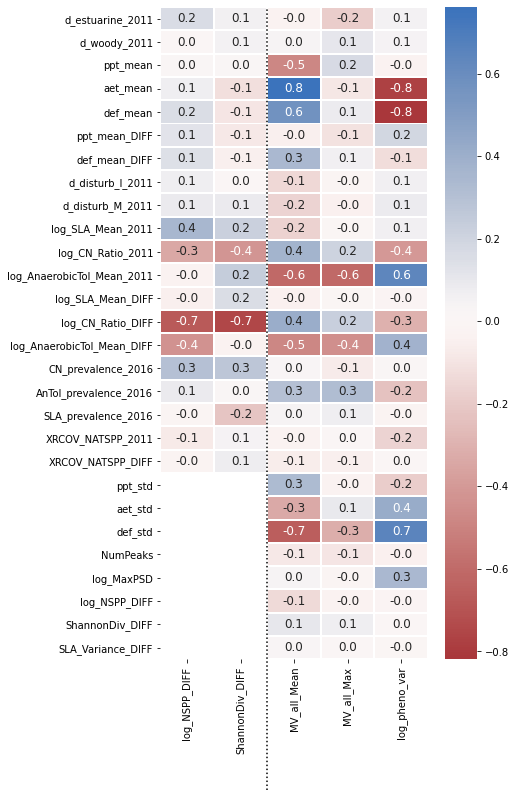

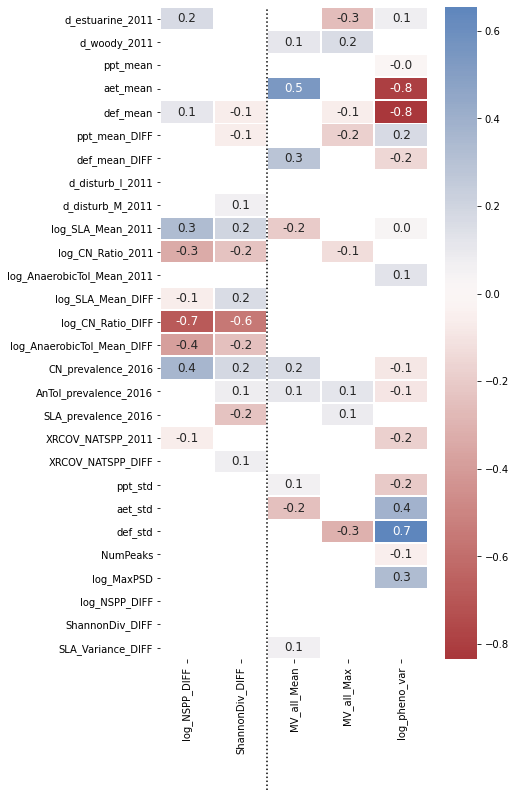

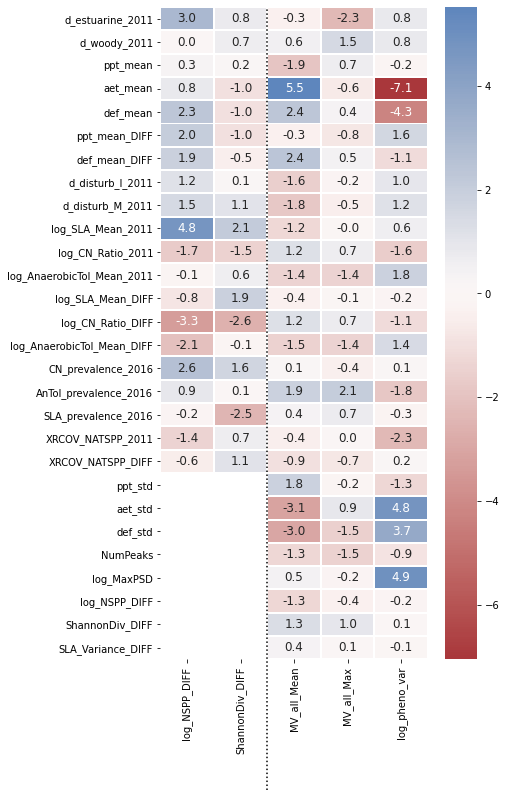

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


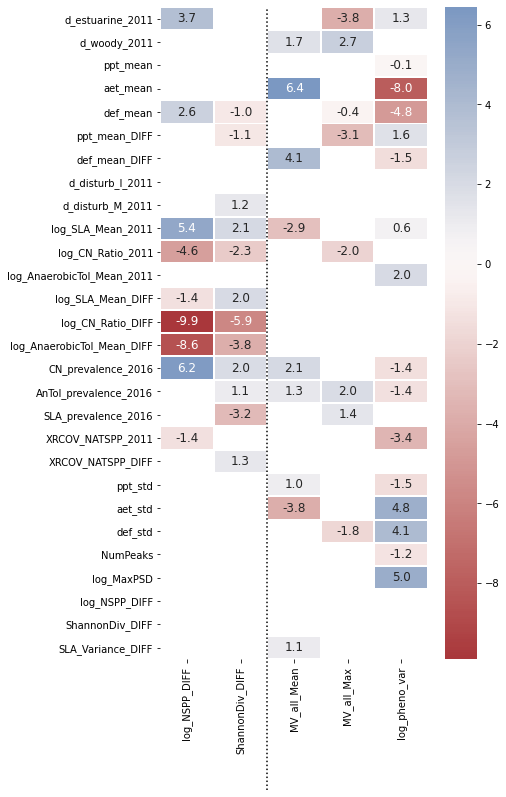

In [34]:
# summarize the lassoed coefficients for the full model
full_model_vars ={
    "log_NSPP_DIFF": dmodels["full"],
    "ShannonDiv_DIFF": dmodels["full"],
    "MV_all_Mean": smodels["full"],
    "MV_all_Max": smodels["full"],
    "log_pheno_var": smodels["full"],
}

# WITHOUT LASSO (try .params or .tvalues)
full_model_params = {y: exec_ols(y=df[y], X=df[full_model_vars[y]]).params for y in full_model_vars} 
xs = dmodels["full"] + [x for x in smodels["full"] if x not in dmodels["full"]]
full_model_params = pd.concat(full_model_params).unstack().T.reindex(pd.Index(xs))

fig, ax = plt.subplots()
sns.heatmap(
            #np.absolute(full_model_params), cmap="Blues", 
            full_model_params, cmap="vlag_r", center=0,
            ax=ax, xticklabels=True, yticklabels=True, 
            cbar=True, linewidths=1, linecolor="white",
            annot=True, annot_kws={"size": 12}, fmt=".1f")
ax.axvline(x=2, color="black", ls=":", clip_on=False, ymin=-0.2)
fig.set_size_inches(6, 12)
plt.show()

# WITH LASSO (try .params or .tvalues)
full_model_params = {y: optimize_coefficients(df=df, y_var=y, X_vars=full_model_vars[y]).params for y in full_model_vars} 
xs = dmodels["full"] + [x for x in smodels["full"] if x not in dmodels["full"]]
full_model_params = pd.concat(full_model_params).unstack().T.reindex(pd.Index(xs))

fig, ax = plt.subplots()
sns.heatmap(
            #np.absolute(full_model_params), cmap="Blues", 
            full_model_params, cmap="vlag_r", center=0,
            ax=ax, xticklabels=True, yticklabels=True, 
            cbar=True, linewidths=1, linecolor="white",
            annot=True, annot_kws={"size": 12}, fmt=".1f")
ax.axvline(x=2, color="black", ls=":", clip_on=False, ymin=-0.2)
fig.set_size_inches(6, 12)
plt.show()

# WITHOUT LASSO (try .params or .tvalues)
full_model_params = {y: exec_ols(y=df[y], X=df[full_model_vars[y]]).tvalues for y in full_model_vars} 
xs = dmodels["full"] + [x for x in smodels["full"] if x not in dmodels["full"]]
full_model_params = pd.concat(full_model_params).unstack().T.reindex(pd.Index(xs))

fig, ax = plt.subplots()
sns.heatmap(
            #np.absolute(full_model_params), cmap="Blues", 
            full_model_params, cmap="vlag_r", center=0,
            ax=ax, xticklabels=True, yticklabels=True, 
            cbar=True, linewidths=1, linecolor="white",
            annot=True, annot_kws={"size": 12}, fmt=".1f")
ax.axvline(x=2, color="black", ls=":", clip_on=False, ymin=-0.2)
fig.set_size_inches(6, 12)
plt.show()

# WITH LASSO (try .params or .tvalues)
full_model_params = {y: optimize_coefficients(df=df, y_var=y, X_vars=full_model_vars[y]).tvalues for y in full_model_vars} 
xs = dmodels["full"] + [x for x in smodels["full"] if x not in dmodels["full"]]
full_model_params = pd.concat(full_model_params).unstack().T.reindex(pd.Index(xs))

fig, ax = plt.subplots()
sns.heatmap(
            #np.absolute(full_model_params), cmap="Blues", 
            full_model_params, cmap="vlag_r", center=0,
            ax=ax, xticklabels=True, yticklabels=True, 
            cbar=True, linewidths=1, linecolor="white",
            annot=True, annot_kws={"size": 12}, fmt=".1f")
ax.axvline(x=2, color="black", ls=":", clip_on=False, ymin=-0.2)
fig.set_size_inches(6, 12)
plt.show()

# plotting outputs

In [36]:
#   selected_yvar = "MV_all_Mean"
#   selected_model = "s5"
#   alpha = 0.05
#   
#   # "HC0_se" for heterosked-robust SE, "bse" for normal
#   reg = regs_stability.loc[selected_yvar].loc[selected_model]
#   d = pd.concat([reg.params, reg.HC0_se, reg.conf_int(alpha=alpha)], axis="columns").rename_axis("variable")
#   d.columns = ["param", "se", "ci_min", "ci_max"]
#   tcrit = scipy.stats.t.ppf(1 - alpha, reg.df_resid)
#   d = (d
#        .sort_values("param")
#        .reset_index()
#        .assign(ci = lambda d: tcrit * d["se"])
#        .assign(significant = lambda d: np.sign(d["param"] + d["ci"]) == np.sign(d["param"] - d["ci"]))
#        )
#   
#   fig, ax = plt.subplots()
#   plt.errorbar(y=d["variable"], x=d["param"], xerr=d["ci"]*~d["significant"], ls="none")
#   plt.errorbar(y=d["variable"], x=d["param"], xerr=d["ci"]*d["significant"], ls="none")
#   sns.pointplot(y=d["variable"], x=d["param"], hue=d["significant"], join=False)
#   ax.axvline(x=0, ls=":", color="black")
#   fig.set_size_inches(12, 12)
#   ax.set_title(f"predictors of {selected_yvar} (model {selected_model})")
#   ax.set_xlabel(f"standardized parameter estimate (±CI, α={alpha})")
#   ax.set_ylabel("")
#   sns.despine(trim=True)
#   plt.show()

Text(0.5, 1.0, 'log Phenological Variation')

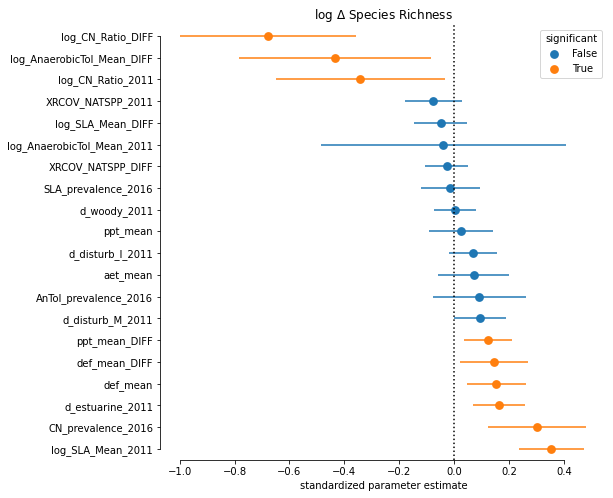

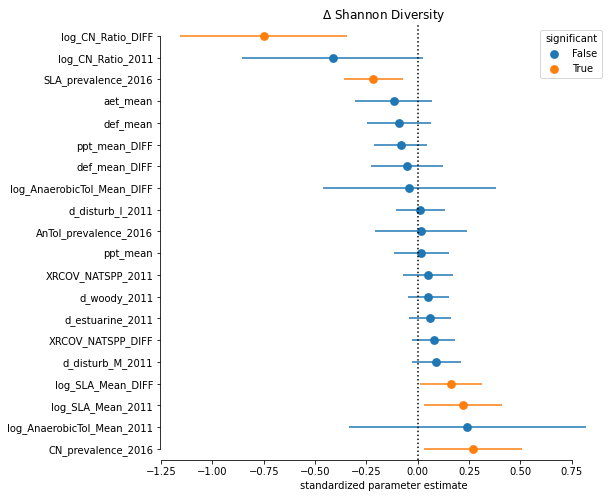

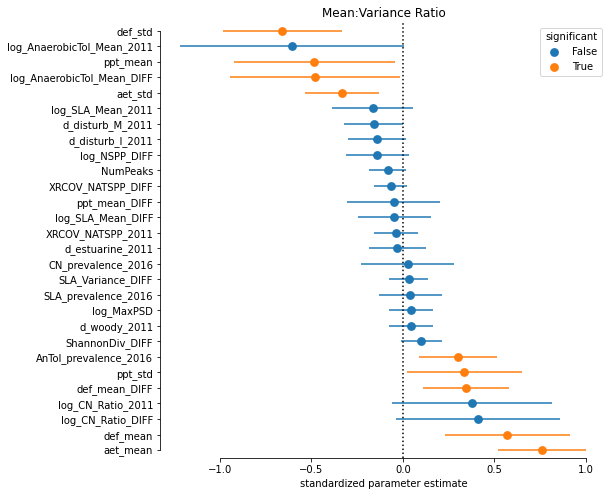

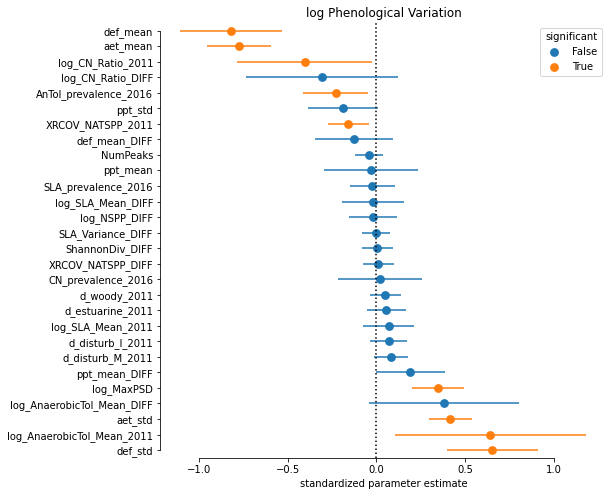

In [37]:
def plot_estimates(reg, alpha=0.05):
    d = pd.concat([reg.params, reg.HC0_se, reg.conf_int(alpha=alpha)], axis="columns").rename_axis("variable")
    d.columns = ["param", "se", "ci_min", "ci_max"]
    tcrit = scipy.stats.t.ppf(1 - alpha, reg.df_resid)
    d = (d
        .sort_values("param")
        .reset_index()
        .assign(ci = lambda d: tcrit * d["se"])
        .assign(significant = lambda d: np.sign(d["param"] + d["ci"]) == np.sign(d["param"] - d["ci"]))
        )
    fig, ax = plt.subplots()
    plt.errorbar(y=d["variable"], x=d["param"], xerr=d["ci"]*~d["significant"], ls="none")
    plt.errorbar(y=d["variable"], x=d["param"], xerr=d["ci"]*d["significant"], ls="none")
    sns.pointplot(ax=ax, y=d["variable"], x=d["param"], hue=d["significant"], join=False)
    plt.axvline(x=0, ls=":", color="black")
    plt.xlabel("standardized parameter estimate")
    plt.ylabel("")
    sns.despine(ax=ax, trim=True)
    fig.set_size_inches(8, 8)
    return ax

plot_estimates(regs_diversity.loc["log_NSPP_DIFF"].loc["full"]).set_title("log $\Delta$ Species Richness")
plot_estimates(regs_diversity.loc["ShannonDiv_DIFF"].loc["full"]).set_title("$\Delta$ Shannon Diversity")
plot_estimates(regs_stability.loc["MV_all_Mean"].loc["full"]).set_title("Mean:Variance Ratio")
plot_estimates(regs_stability.loc["log_pheno_var"].loc["full"]).set_title("log Phenological Variation")

Text(0.5, 1.0, 'log Phenological Variation')

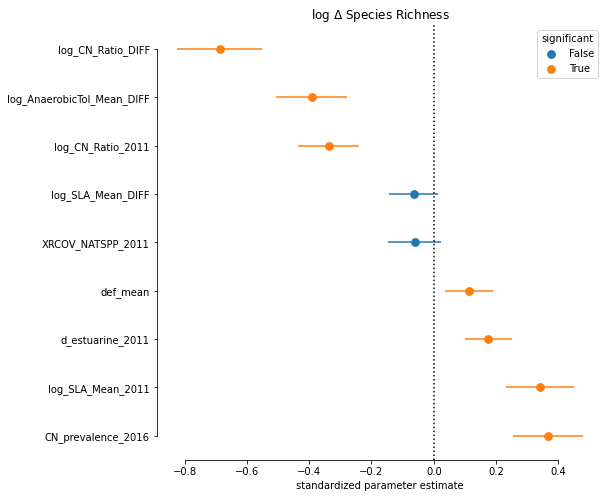

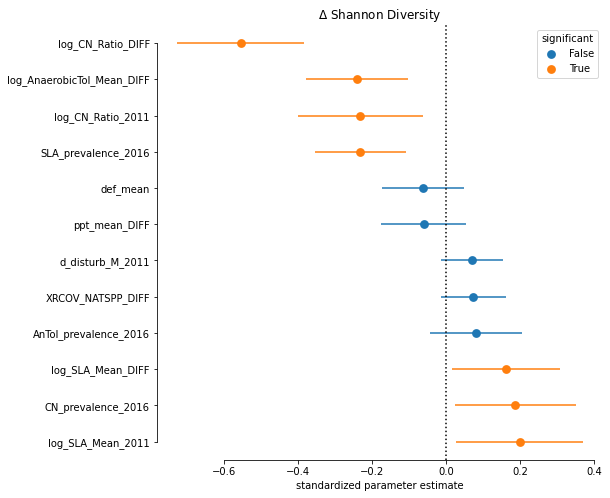

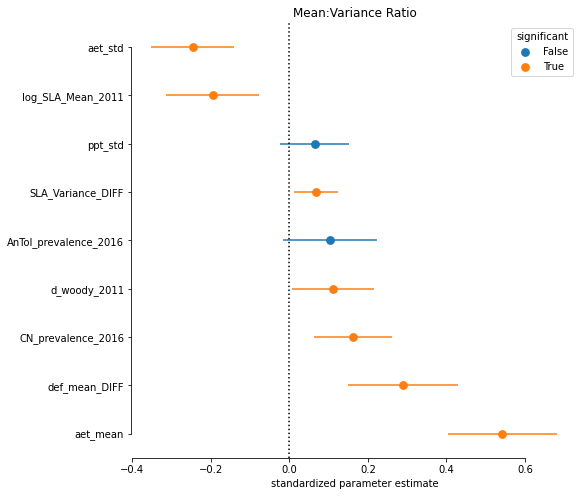

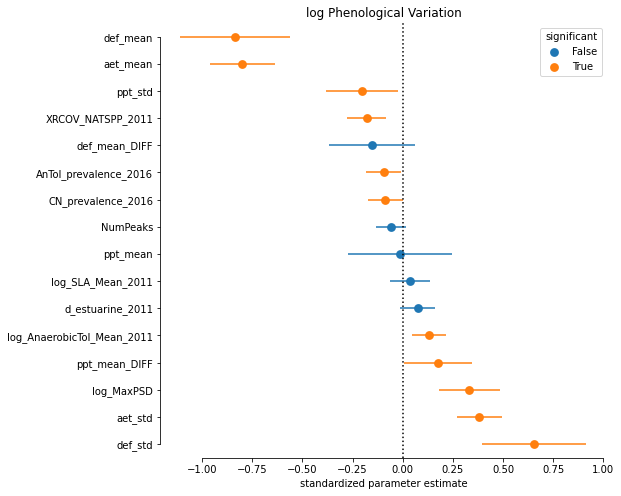

In [38]:
plot_estimates(regs_diversity_lasso.loc["log_NSPP_DIFF"].loc["full"]).set_title("log $\Delta$ Species Richness")
plot_estimates(regs_diversity_lasso.loc["ShannonDiv_DIFF"].loc["full"]).set_title("$\Delta$ Shannon Diversity")
plot_estimates(regs_stability_lasso.loc["MV_all_Mean"].loc["full"]).set_title("Mean:Variance Ratio")
plot_estimates(regs_stability_lasso.loc["log_pheno_var"].loc["full"]).set_title("log Phenological Variation")

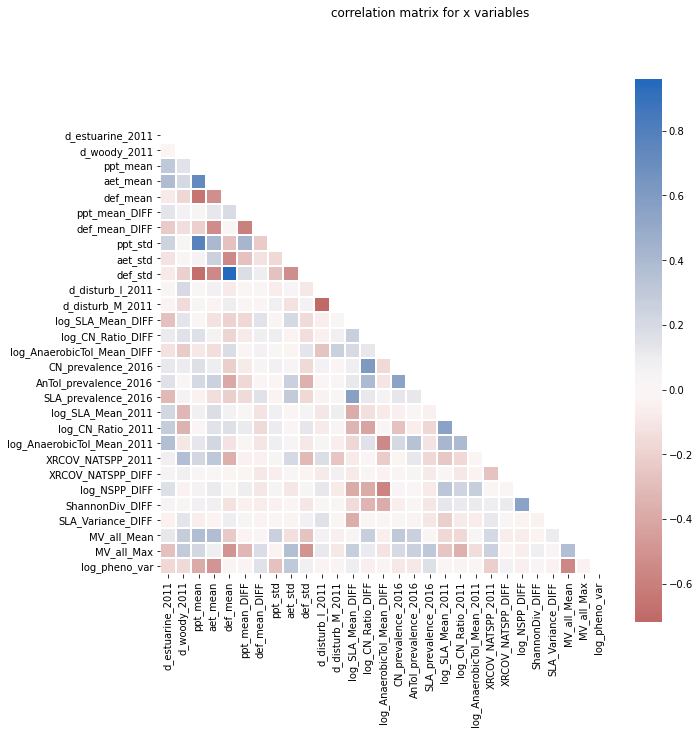

In [42]:
# specific correlation grid heat maps: row = x, col = y

yv = ["log_NSPP_DIFF", "ShannonDiv_DIFF", "MV_all_Mean", "MV_all_Max", "log_pheno_var"]
#xv = dmodels["d4"]
#xv += [x for x in smodels["s5"] if x not in xv]
xv = vars_attributes + vars_climate + vars_dif_climate + vars_climate_variability + vars_disturb + vars_dif_traits + vars_traits_prev + vars_traits_baseline + vars_dif_native + vars_dif_taxo_div + vars_dif_func_div + vars_stability
df = flatten_columns(sites).copy().select_dtypes(include=np.number)
df[:] = scale(df[:])

#   corr_pairs = pd.MultiIndex.from_product([xv, yv]).to_series().unstack()
#   corr_pairs.index = pd.CategoricalIndex(corr_pairs.index, categories=xv)
#   corr_pairs.sort_index(axis=0, inplace=True)
#   corr_pairs.columns = pd.CategoricalIndex(corr_pairs.columns, categories=yv)
#   corr_pairs.sort_index(axis=1, inplace=True)
#   
#   def get_corr(t: tuple, df: pd.DataFrame) -> float:
#       x_var = t[0]
#       y_var = t[1]
#       d = df.copy().dropna(subset=[x_var, y_var])
#       x = d[x_var]
#       y = d[y_var]
#       r, p = scipy.stats.pearsonr(x, y)
#       return r if x_var!=y_var else np.nan
#   
#   corr_mat = corr_pairs.applymap(lambda t: get_corr(t, df)**2)
#   
#   fig, ax = plt.subplots()
#   sns.heatmap(corr_mat, ax=ax,
#               xticklabels=True, yticklabels=True, 
#               cbar=True, cmap="Blues", linewidths=1, linecolor="white")
#   fig.set_size_inches(6,12)
#   fig.suptitle("correlations between y and x variables")
#   plt.show()

# squared covariance matrix (R2 if data are standardized)
x_corr = pd.DataFrame(np.cov(df[xv].dropna().T), index=xv, columns=xv)
fig, ax = plt.subplots()
sns.heatmap(x_corr, mask=np.triu(np.ones_like(x_corr, dtype=bool)), 
            ax=ax, xticklabels=True, yticklabels=True, 
            cmap="vlag_r", center=0, cbar=True, linewidths=1, linecolor="white")
fig.set_size_inches(10,10)
ax.set_aspect('equal')
fig.suptitle("correlation matrix for x variables")
plt.show()

# Sequential Models Version 2

y                                 log_NSPP_DIFF         ... ShannonDiv_DIFF       
model                                      none     SL  ...              NS   full
                           output                       ...                       
d_estuarine_2011           coeff          +0.01  +0.06  ...           +0.03  +0.04
                           P                            ...                       
d_woody_2011               coeff          −0.03  +0.05  ...           −0.04  +0.06
                           P                            ...                       
d_disturb_I_2011           coeff          +0.12  +0.13  ...           +0.01  +0.02
                           P                            ...                       
d_disturb_M_2011           coeff          +0.00  +0.03  ...           +0.00  +0.09
                           P                            ...                       
ppt_mean                   coeff          +0.17  +0.26  ...           +0.21  −0.00
                           P                            ...                       
aet_mean                   coeff          +0.02  −0.05  ...           −0.20  −0.17
                           P                            ...                       
def_mean                   coeff          +0.03  −0.23  ...           −0.43  −0.55
                           P                            ...              **    ***
ppt_std                    coeff          −0.12  −0.23  ...           −0.18  +0.03
                           P                            ...                       
aet_std                    coeff          −0.07  −0.09  ...           −0.14  −0.12
                           P                            ...                       
def_std                    coeff          +0.14  +0.33  ...           +0.40  +0.41
                           P                         *  ...               *     **
ppt_mean_DIFF              coeff          +0.06  +0.10  ...           −0.20  −0.21
                           P                            ...                       
def_mean_DIFF              coeff          −0.05  +0.04  ...           −0.31  −0.20
                           P                            ...              **       
log_SLA_Mean_2011          coeff                 +0.25  ...                  +0.20
                           P                       ***  ...                      *
log_SLA_Mean_DIFF          coeff                 −0.36  ...                  +0.13
                           P                       ***  ...                       
SLA_prevalence_2016        coeff                 +0.15  ...                  −0.19
                           P                         *  ...                     **
log_CN_Ratio_2011          coeff                        ...                  −0.36
                           P                            ...                       
log_CN_Ratio_DIFF          coeff                        ...                  −0.76
                           P                            ...                    ***
CN_prevalence_2016         coeff                        ...                  +0.26
                           P                            ...                       
log_AnaerobicTol_Mean_2011 coeff                        ...                  +0.23
                           P                            ...                       
log_AnaerobicTol_Mean_DIFF coeff                        ...                  −0.02
                           P                            ...                       
AnTol_prevalence_2016      coeff                        ...                  +0.02
                           P                            ...                       
XRCOV_NATSPP_2011          coeff                        ...           +0.11  +0.05
                           P                            ...               *       
XRCOV_NATSPP_DIFF          coeff                        ...           +0.04  +0.07
                

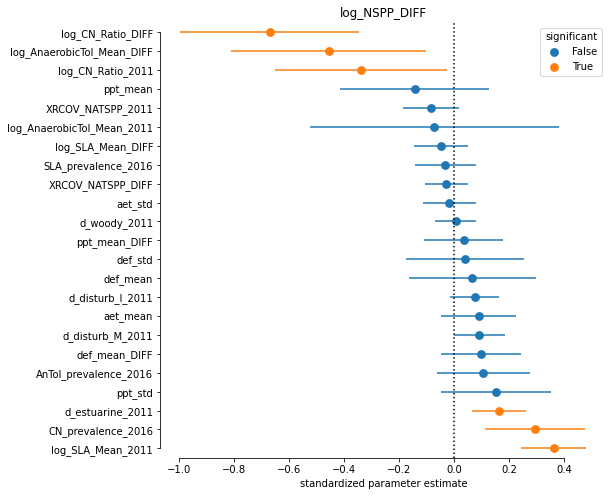

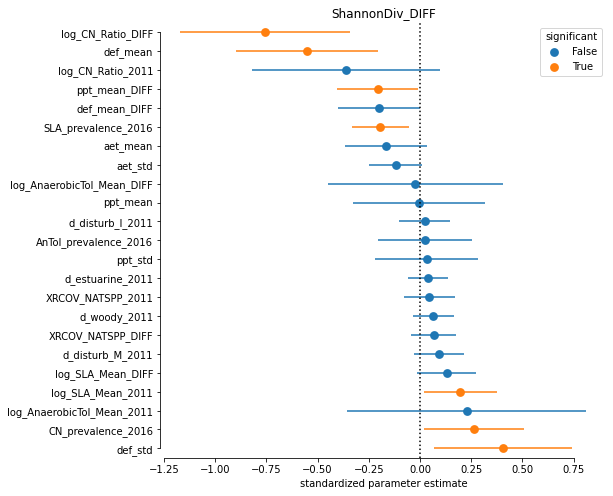

In [71]:
vars_traits_SL = ["log_SLA_Mean_2011", "log_SLA_Mean_DIFF", "SLA_prevalence_2016"]
vars_traits_CN = ["log_CN_Ratio_2011", "log_CN_Ratio_DIFF", "CN_prevalence_2016"]
vars_traits_AT = ["log_AnaerobicTol_Mean_2011", "log_AnaerobicTol_Mean_DIFF", "AnTol_prevalence_2016"]
vars_traits_NS = ["XRCOV_NATSPP_2011", "XRCOV_NATSPP_DIFF"]
dmodels2 = {
    "none": vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate, 
    "SL":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_SL,
    "CN":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_CN,
    "AT":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_AT, 
    "NS":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_NS, 
    "full": vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_SL + vars_traits_CN + vars_traits_AT + vars_traits_NS, 
}

regs2_diversity = fit_models(df=df, ys=["log_NSPP_DIFF", "ShannonDiv_DIFF"], Xs=dmodels2)
plot_estimates(regs2_diversity.loc["log_NSPP_DIFF"].loc["full"]).set_title("log_NSPP_DIFF")
plot_estimates(regs2_diversity.loc["ShannonDiv_DIFF"].loc["full"]).set_title("ShannonDiv_DIFF")
output_results(regs2_diversity).to_csv("regs2_diversity.csv")
output_results(regs2_diversity)

y                                 log_NSPP_DIFF         ... ShannonDiv_DIFF       
model                                      none     SL  ...              NS   full
                           output                       ...                       
d_disturb_I_2011           coeff          +0.11  +0.13  ...                       
                           P                  *     **  ...                       
aet_std                    coeff          −0.12  −0.14  ...                  −0.06
                           P                  *     **  ...                       
def_std                    coeff          +0.08         ...                  +0.33
                           P                            ...                      *
def_mean_DIFF              coeff          −0.10         ...                       
                           P                  *         ...                       
log_SLA_Mean_2011          coeff                 +0.23  ...                  +0.19
                           P                       ***  ...                     **
log_SLA_Mean_DIFF          coeff                 −0.35  ...                  +0.15
                           P                       ***  ...                      *
SLA_prevalence_2016        coeff                 +0.13  ...                  −0.22
                           P                         *  ...                    ***
d_estuarine_2011           coeff                        ...                       
                           P                            ...                       
aet_mean                   coeff                        ...                       
                           P                            ...                       
log_CN_Ratio_2011          coeff                        ...                  −0.21
                           P                            ...                     **
log_CN_Ratio_DIFF          coeff                        ...                  −0.57
                           P                            ...                    ***
CN_prevalence_2016         coeff                        ...                  +0.19
                           P                            ...                      *
d_woody_2011               coeff                        ...                       
                           P                            ...                       
def_mean                   coeff                        ...                  −0.41
                           P                            ...                     **
ppt_mean_DIFF              coeff                        ...                  −0.07
                           P                            ...                       
log_AnaerobicTol_Mean_2011 coeff                        ...                       
                           P                            ...                       
log_AnaerobicTol_Mean_DIFF coeff                        ...                  −0.22
                           P                            ...                    ***
XRCOV_NATSPP_2011          coeff                        ...           +0.10       
                           P                            ...               *       
ppt_std                    coeff                        ...                       
                           P                            ...                       
d_disturb_M_2011           coeff                        ...                  +0.07
                           P                            ...                       
AnTol_prevalence_2016      coeff                        ...                  +0.08
                           P                            ...                       
XRCOV_NATSPP_DIFF          coeff                        ...                  +0.08
                           P                            ...                       
_outputs                   R2_adj          0.04   0.25  ...            0.01   0.29
                

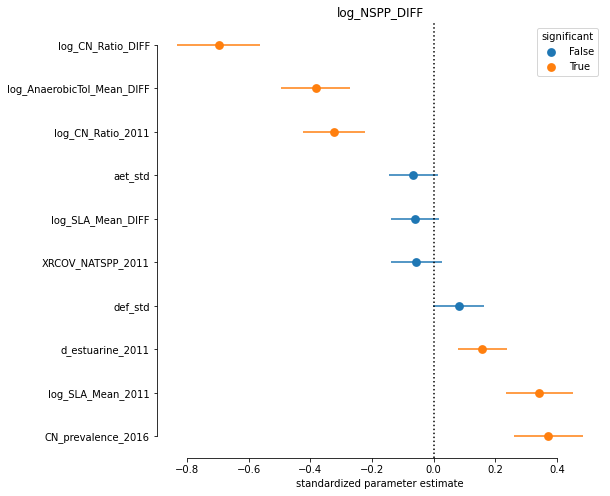

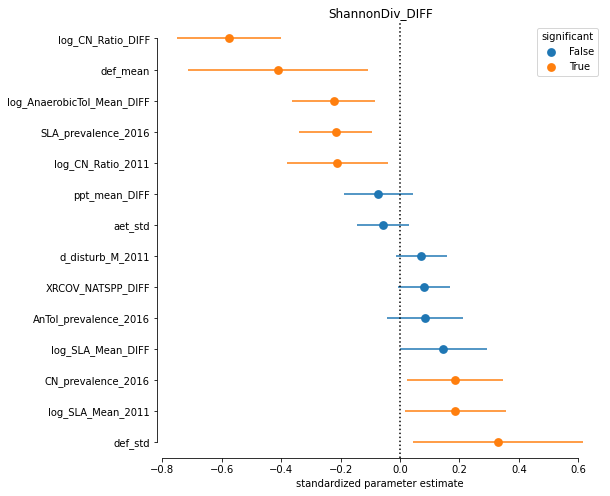

In [72]:
regs2_diversity_lasso = fit_models_lasso(df=df, ys=["log_NSPP_DIFF", "ShannonDiv_DIFF"], Xs=dmodels2)
plot_estimates(regs2_diversity_lasso.loc["log_NSPP_DIFF"].loc["full"]).set_title("log_NSPP_DIFF")
plot_estimates(regs2_diversity_lasso.loc["ShannonDiv_DIFF"].loc["full"]).set_title("ShannonDiv_DIFF")
output_results(regs2_diversity_lasso)

y                                 MV_all_Mean         ... log_pheno_var       
model                                    none     SL  ...           div   full
                           output                     ...                     
d_estuarine_2011           coeff        −0.09  +0.02  ...         +0.12  +0.08
                           P                          ...            **       
d_woody_2011               coeff        +0.23  +0.09  ...         −0.07  +0.07
                           P              ***         ...                     
d_disturb_I_2011           coeff        +0.00  −0.10  ...         +0.04  +0.06
                           P                          ...                     
d_disturb_M_2011           coeff        −0.00  −0.10  ...         +0.03  +0.07
                           P                          ...                     
ppt_mean                   coeff        −0.42  −0.42  ...         +0.13  +0.14
                           P                *      *  ...                     
aet_mean                   coeff        +0.66  +0.78  ...         −0.88  −0.83
                           P              ***    ***  ...           ***    ***
def_mean                   coeff        +0.17  +0.33  ...         −0.98  −1.17
                           P                          ...           ***    ***
ppt_std                    coeff        +0.33  +0.31  ...         −0.16  −0.18
                           P               **      *  ...                     
aet_std                    coeff        −0.31  −0.35  ...         +0.38  +0.38
                           P              ***    ***  ...           ***    ***
def_std                    coeff        −0.42  −0.52  ...         +0.77  +0.86
                           P               **     **  ...           ***    ***
ppt_mean_DIFF              coeff        −0.08  −0.10  ...         +0.14  +0.14
                           P                          ...                     
def_mean_DIFF              coeff        +0.35  +0.32  ...         −0.25  −0.18
                           P              ***     **  ...            **       
log_SLA_Mean_2011          coeff               −0.28  ...                −0.01
                           P                     ***  ...                     
log_SLA_Mean_DIFF          coeff               −0.08  ...                −0.09
                           P                          ...                     
SLA_prevalence_2016        coeff               +0.15  ...                +0.02
                           P                       *  ...                     
log_CN_Ratio_2011          coeff                      ...                −0.41
                           P                          ...                     
log_CN_Ratio_DIFF          coeff                      ...                −0.37
                           P                          ...                     
CN_prevalence_2016         coeff                      ...                +0.06
                           P                          ...                     
log_AnaerobicTol_Mean_2011 coeff                      ...                +0.72
                           P                          ...                    *
log_AnaerobicTol_Mean_DIFF coeff                      ...                +0.46
                           P                          ...                     
AnTol_prevalence_2016      coeff                      ...                −0.30
                           P                          ...                   **
XRCOV_NATSPP_2011          coeff                      ...                −0.15
                           P                          ...                   **
XRCOV_NATSPP_DIFF          coeff                      ...                +0.02
                           P                          ...                     
log_NSPP_DIFF              coeff                      ...         +0.06  −0.00
                           P                      

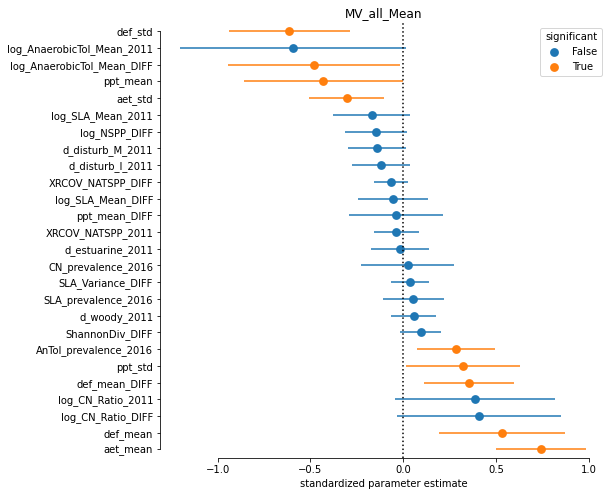

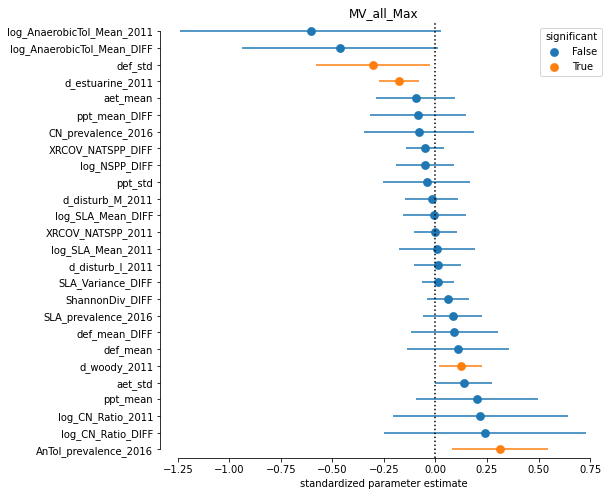

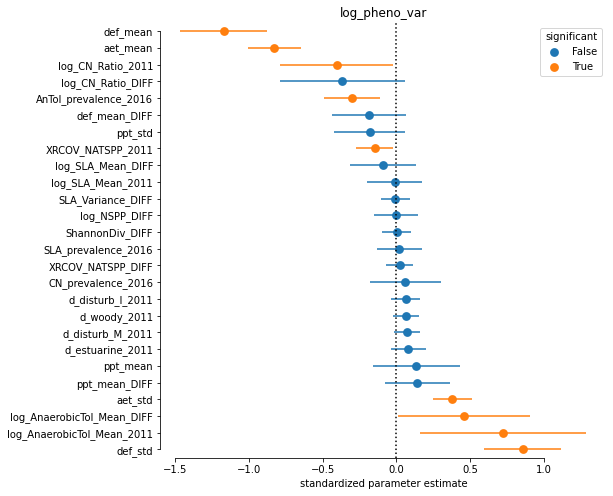

In [73]:
vars_diversity = ["log_NSPP_DIFF", "ShannonDiv_DIFF", "SLA_Variance_DIFF"]
smodels2 = {
    "none": vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate, 
    "SL":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_SL,
    "CN":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_CN,
    "AT":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_AT, 
    "NS":   vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_NS, 
    "div":  vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_diversity,
    "full": vars_attributes + vars_disturb + vars_climate + vars_climate_variability + vars_dif_climate + vars_traits_SL + vars_traits_CN + vars_traits_AT + vars_traits_NS + vars_diversity,
}

regs2_stability = fit_models(df=df, ys=["MV_all_Mean", "MV_all_Max", "log_pheno_var"], Xs=smodels2)
plot_estimates(regs2_stability.loc["MV_all_Mean"].loc["full"]).set_title("MV_all_Mean")
plot_estimates(regs2_stability.loc["MV_all_Max"].loc["full"]).set_title("MV_all_Max")
plot_estimates(regs2_stability.loc["log_pheno_var"].loc["full"]).set_title("log_pheno_var")
output_results(regs2_stability).to_csv("regs2_stability.csv")
output_results(regs2_stability)

y                                 MV_all_Mean         ... log_pheno_var       
model                                    none     SL  ...           div   full
                           output                     ...                     
d_woody_2011               coeff        +0.25  +0.11  ...         −0.07       
                           P              ***         ...                     
ppt_mean                   coeff        −0.34  −0.37  ...                     
                           P                *      *  ...                     
aet_mean                   coeff        +0.60  +0.73  ...         −0.85  −0.82
                           P              ***    ***  ...           ***    ***
ppt_std                    coeff        +0.25  +0.24  ...         −0.08  −0.10
                           P               **     **  ...                     
aet_std                    coeff        −0.28  −0.31  ...         +0.34  +0.34
                           P              ***    ***  ...           ***    ***
def_std                    coeff        −0.25  −0.24  ...         +0.73  +0.80
                           P               **      *  ...           ***    ***
def_mean_DIFF              coeff        +0.39  +0.36  ...         −0.27  −0.22
                           P              ***    ***  ...            **     **
log_SLA_Mean_2011          coeff               −0.22  ...                     
                           P                     ***  ...                     
d_estuarine_2011           coeff                      ...         +0.12  +0.11
                           P                          ...            **      *
def_mean                   coeff                      ...         −1.00  −1.18
                           P                          ...           ***    ***
log_CN_Ratio_2011          coeff                      ...                     
                           P                          ...                     
CN_prevalence_2016         coeff                      ...                −0.09
                           P                          ...                     
log_AnaerobicTol_Mean_2011 coeff                      ...                +0.12
                           P                          ...                   **
AnTol_prevalence_2016      coeff                      ...                −0.14
                           P                          ...                    *
log_NSPP_DIFF              coeff                      ...         +0.07       
                           P                          ...                     
SLA_Variance_DIFF          coeff                      ...                     
                           P                          ...                     
ppt_mean_DIFF              coeff                      ...         +0.09  +0.09
                           P                          ...                     
SLA_prevalence_2016        coeff                      ...                     
                           P                          ...                     
log_CN_Ratio_DIFF          coeff                      ...                     
                           P                          ...                     
log_AnaerobicTol_Mean_DIFF coeff                      ...                     
                           P                          ...                     
XRCOV_NATSPP_2011          coeff                      ...                −0.18
                           P                          ...                  ***
log_SLA_Mean_DIFF          coeff                      ...                −0.06
                           P                          ...                     
_outputs                   R2_adj        0.33   0.38  ...          0.52   0.61
                           AIC         518.18 460.18  ...        452.10 380.79

[46 rows x 21 columns]

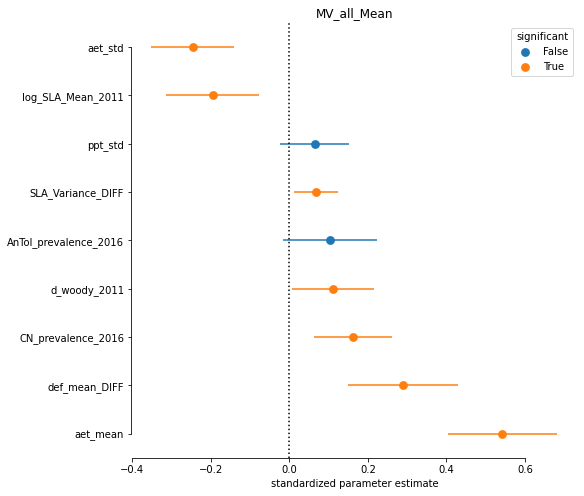

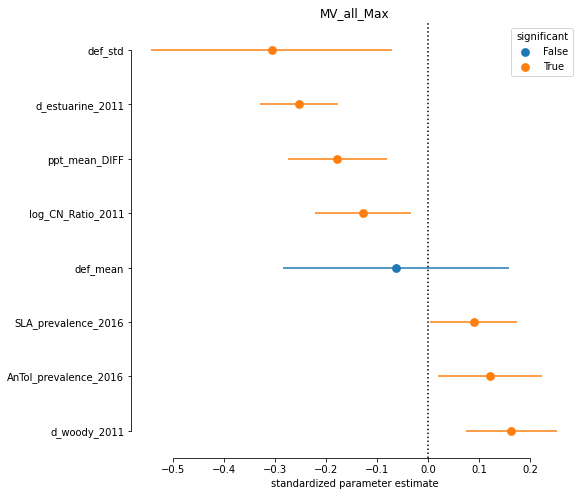

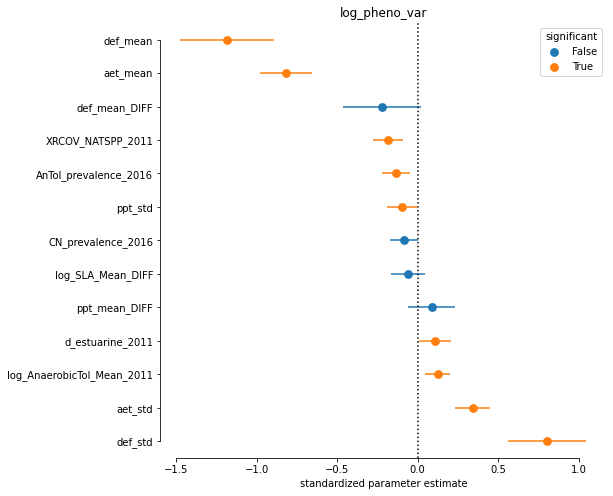

In [74]:
regs2_stability_lasso = fit_models_lasso(df=df, ys=["MV_all_Mean", "MV_all_Max", "log_pheno_var"], Xs=smodels2)
plot_estimates(regs2_stability_lasso.loc["MV_all_Mean"].loc["full"]).set_title("MV_all_Mean")
plot_estimates(regs2_stability_lasso.loc["MV_all_Max"].loc["full"]).set_title("MV_all_Max")
plot_estimates(regs2_stability_lasso.loc["log_pheno_var"].loc["full"]).set_title("log_pheno_var")
output_results(regs2_stability_lasso)

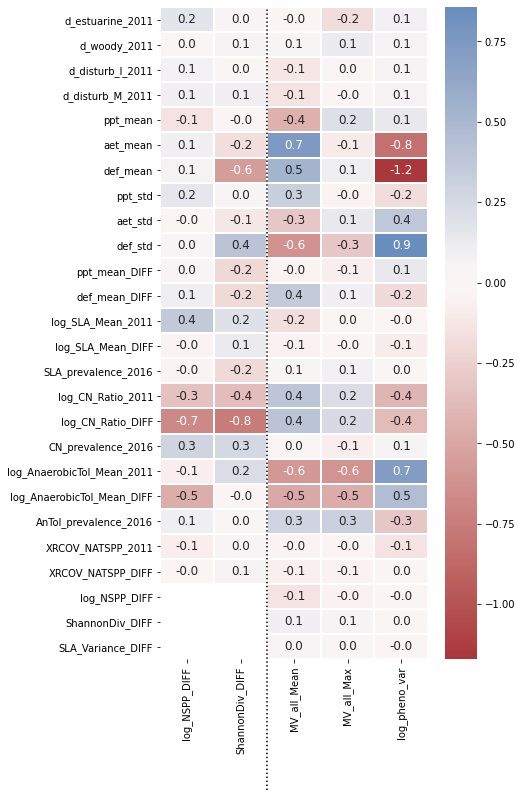

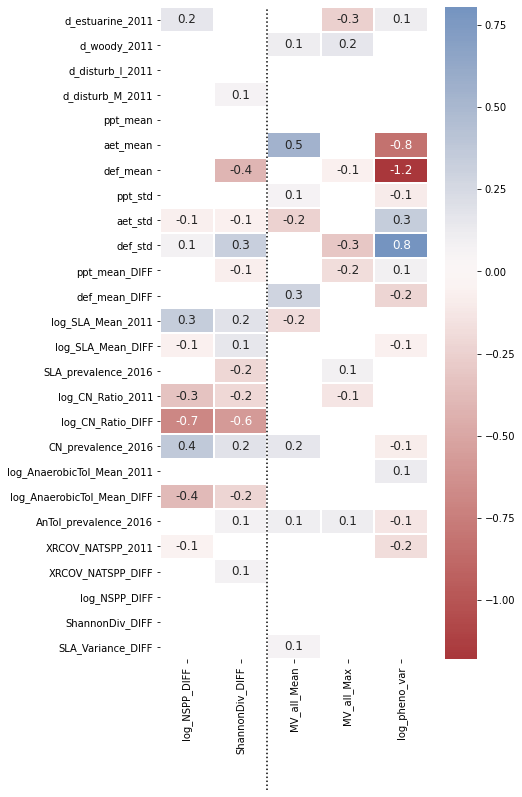

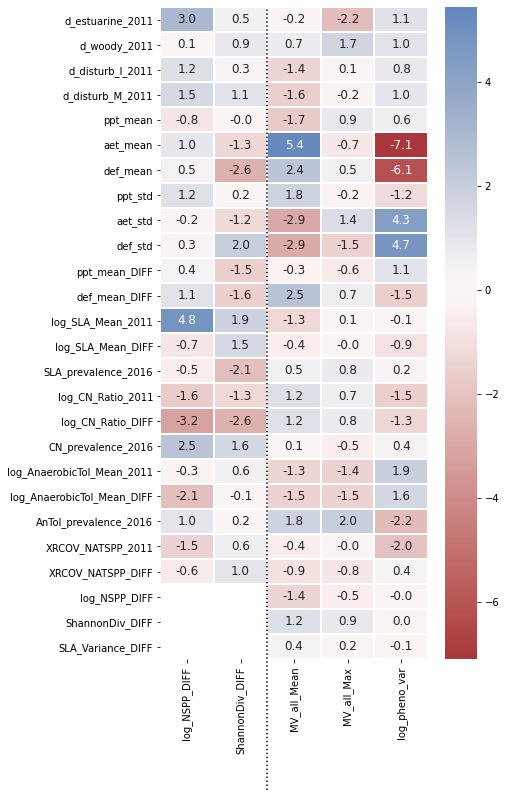

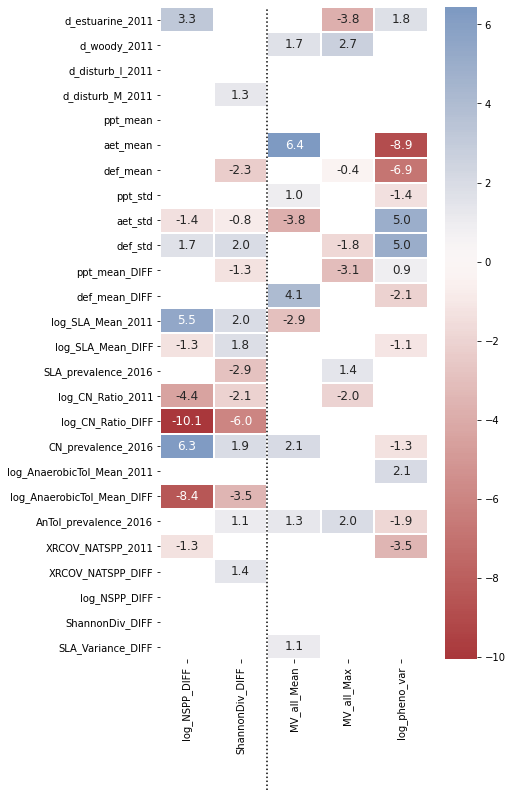

In [75]:
# summarize the lassoed coefficients for the full model
full_model_vars ={
    "log_NSPP_DIFF": dmodels2["full"],
    "ShannonDiv_DIFF": dmodels2["full"],
    "MV_all_Mean": smodels2["full"],
    "MV_all_Max": smodels2["full"],
    "log_pheno_var": smodels2["full"],
}

# WITHOUT LASSO (try .params or .tvalues)
full_model_params = {y: exec_ols(y=df[y], X=df[full_model_vars[y]]).params for y in full_model_vars} 
xs = dmodels2["full"] + [x for x in smodels2["full"] if x not in dmodels2["full"]]
full_model_params = pd.concat(full_model_params).unstack().T.reindex(pd.Index(xs))

fig, ax = plt.subplots()
sns.heatmap(
            #np.absolute(full_model_params), cmap="Blues", 
            full_model_params, cmap="vlag_r", center=0,
            ax=ax, xticklabels=True, yticklabels=True, 
            cbar=True, linewidths=1, linecolor="white",
            annot=True, annot_kws={"size": 12}, fmt=".1f")
ax.axvline(x=2, color="black", ls=":", clip_on=False, ymin=-0.2)
fig.set_size_inches(6, 12)
plt.show()

# WITH LASSO (try .params or .tvalues)
full_model_params = {y: optimize_coefficients(df=df, y_var=y, X_vars=full_model_vars[y]).params for y in full_model_vars} 
xs = dmodels2["full"] + [x for x in smodels2["full"] if x not in dmodels2["full"]]
full_model_params = pd.concat(full_model_params).unstack().T.reindex(pd.Index(xs))

fig, ax = plt.subplots()
sns.heatmap(
            #np.absolute(full_model_params), cmap="Blues", 
            full_model_params, cmap="vlag_r", center=0,
            ax=ax, xticklabels=True, yticklabels=True, 
            cbar=True, linewidths=1, linecolor="white",
            annot=True, annot_kws={"size": 12}, fmt=".1f")
ax.axvline(x=2, color="black", ls=":", clip_on=False, ymin=-0.2)
fig.set_size_inches(6, 12)
plt.show()

# WITHOUT LASSO (try .params or .tvalues)
full_model_params = {y: exec_ols(y=df[y], X=df[full_model_vars[y]]).tvalues for y in full_model_vars} 
xs = dmodels2["full"] + [x for x in smodels2["full"] if x not in dmodels2["full"]]
full_model_params = pd.concat(full_model_params).unstack().T.reindex(pd.Index(xs))

fig, ax = plt.subplots()
sns.heatmap(
            #np.absolute(full_model_params), cmap="Blues", 
            full_model_params, cmap="vlag_r", center=0,
            ax=ax, xticklabels=True, yticklabels=True, 
            cbar=True, linewidths=1, linecolor="white",
            annot=True, annot_kws={"size": 12}, fmt=".1f")
ax.axvline(x=2, color="black", ls=":", clip_on=False, ymin=-0.2)
fig.set_size_inches(6, 12)
plt.show()

# WITH LASSO (try .params or .tvalues)
full_model_params = {y: optimize_coefficients(df=df, y_var=y, X_vars=full_model_vars[y]).tvalues for y in full_model_vars} 
xs = dmodels2["full"] + [x for x in smodels2["full"] if x not in dmodels2["full"]]
full_model_params = pd.concat(full_model_params).unstack().T.reindex(pd.Index(xs))

fig, ax = plt.subplots()
sns.heatmap(
            #np.absolute(full_model_params), cmap="Blues", 
            full_model_params, cmap="vlag_r", center=0,
            ax=ax, xticklabels=True, yticklabels=True, 
            cbar=True, linewidths=1, linecolor="white",
            annot=True, annot_kws={"size": 12}, fmt=".1f")
ax.axvline(x=2, color="black", ls=":", clip_on=False, ymin=-0.2)
fig.set_size_inches(6, 12)
plt.show()

-----------
# TEST below this line

In [41]:
assert False

AssertionError: ignored

# test for spatial autocorrelation

In [35]:
# Moran's I for spatial autocorrelation

#   # random array for testing
#   Z = np.random.rand(3,2)
#   # create weight matrix
#   w = lat2W(Z.shape[0], Z.shape[1])
#   # for xarray, can create 
#   # from libpysal.weights import Queen
#   # Queen.from_xarray()
#   # calculate Moran's I
#   mi = Moran(Z, w)
#   # print("I=", mi.I, "P=", mi.p_norm)

# nearest neighbor weights
# w = KNN.from_dataframe(sites_gdf)
#   mi = Moran(sites_gdf[("NSPP", "2011")], w)
#   print("I=", mi.I, "P=", mi.p_norm)

#   # Apply to DataFrame:
#   def test_moran(gdf: gpd.GeoDataFrame) -> pd.DataFrame:
#       w = KNN.from_dataframe(gdf)
#       return (gdf
#               .select_dtypes("number")
#               .apply(lambda s: Moran(s, w))
#               .apply(lambda x: {"I":x.I, "P":x.p_norm})
#               .apply(lambda x:pd.Series(x))
#               .sort_values("I", ascending=False)
#               .dropna()
#       )
#   test_moran(df.join(sites_gdf["geometry"].rename("geometry"))[["geometry", "Latitude_2016"]])


# see http://darribas.org/gds15/content/labs/lab_06.html
# see https://splot.readthedocs.io/en/stable/users/tutorials/weights.html#distance-based-weights 

In [40]:
#!pip install semopy
import semopy
f = """
        climate =~ def_mean + ppt_mean + aet_mean + def_std + ppt_std
        diversity =~ log_NSPP_DIFF + ShannonDiv_DIFF
        stability =~ log_pheno_var + MV_all_Mean + MV_all_Max
        traits =~ log_SLA_Mean_DIFF + log_CN_Ratio_DIFF + log_AnaerobicTol_Mean_DIFF

        stability ~ diversity + traits + climate
        diversity ~ traits + climate
      """

f = """
        log_pheno_var, MV_all_Mean, MV_all_Max ~ log_NSPP_DIFF + ShannonDiv_DIFF + log_SLA_Mean_DIFF + log_CN_Ratio_DIFF + log_AnaerobicTol_Mean_DIFF + def_mean + ppt_mean + aet_mean + def_std + ppt_std
        log_NSPP_DIFF, ShannonDiv_DIFF ~ log_SLA_Mean_DIFF + log_CN_Ratio_DIFF + log_AnaerobicTol_Mean_DIFF + def_mean + ppt_mean + aet_mean + def_std + ppt_std
      """

mod = semopy.Model(f)

df = flatten_columns(sites)
mod.load_data(df)
mod.fit(df)
estimates = mod.inspect()
g = semopy.semplot(mod, "sem.png")

estimates

ModuleNotFoundError: ignored

# Random Forest Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

y_var = "log_NSPP_DIFF"
#y_var = "ShannonDiv_DIFF"
X_vars = vars_attributes + vars_climate + vars_dif_climate + vars_disturb + vars_dif_traits + vars_traits_prev + vars_dif_native
#y_var = "MV_all_Mean"
#y_var = "log_pheno_var"
#X_vars = vars_attributes + vars_climate + vars_climate_variability + vars_dif_climate + vars_disturb + vars_stab_ts + vars_dif_taxo_div + vars_dif_func_div + vars_dif_traits + vars_dif_native

df = flatten_columns(sites).copy().select_dtypes(include=np.number).dropna(subset= [y_var] + X_vars)
df[:] = scale(df[:])

y, X = df[y_var], df[X_vars]
y_train, y_test, X_train, X_test = train_test_split(y, X, random_state=47)

ols = LinearRegression(fit_intercept=False, normalize=False, copy_X=True)
rfr = RandomForestRegressor(n_estimators=1024, random_state=47)

ols.fit(X=X_train, y=y_train)
rfr.fit(X=X_train, y=y_train)

y_pred_ols, y_pred_ols_insample = ols.predict(X=X_test), ols.predict(X=X_train)
y_pred_rfr, y_pred_rfr_insample = rfr.predict(X=X_test), rfr.predict(X=X_train)

print("ols", "r2", r2_score(y_test, y_pred_ols), "mse", mean_squared_error(y_test, y_pred_ols))
print("rfr", "r2", r2_score(y_test, y_pred_rfr), "mse", mean_squared_error(y_test, y_pred_rfr))

g = plot_actual_vs_predicted(y_test, y_pred_ols)
sns.scatterplot(x=y_train, y=y_pred_ols_insample, ax=g.ax_joint, facecolor="none", edgecolor="black", alpha=0.5)
g.ax_joint.axvline(x=0, color="black", ls=":")
g.ax_joint.axhline(y=0, color="black", ls=":")
g.ax_marg_x.axvline(x=0, color="black", ls=":")
g.ax_marg_y.axhline(y=0, color="black", ls=":")
plt.show()

g = plot_actual_vs_predicted(y_test, y_pred_rfr)
sns.scatterplot(x=y_train, y=y_pred_ols_insample, ax=g.ax_joint, facecolor="none", edgecolor="black", alpha=0.5)
g.ax_joint.axvline(x=0, color="black", ls=":")
g.ax_joint.axhline(y=0, color="black", ls=":")
g.ax_marg_x.axvline(x=0, color="black", ls=":")
g.ax_marg_y.axhline(y=0, color="black", ls=":")
plt.show()